# Предсказание проката велосипедов


### 1. Cформировать набор данных

#### 1.1. Загружаем библиотеки

In [3]:
# Импорт библиотек
import pandas as pd
import datetime as dt
import numpy as np
import seaborn as sns
import copy
import math
import matplotlib

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

In [5]:
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge
from sklearn.preprocessing import PolynomialFeatures, SplineTransformer
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, BaggingRegressor
from sklearn.model_selection import cross_validate, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, r2_score, make_scorer
from sklearn.model_selection import train_test_split

import statsmodels.api as sm
import scipy.stats as sts

import tensorflow
from tensorflow import keras

In [6]:
import warnings
warnings.filterwarnings('ignore')

#### 1.2. Загрузим данные

In [7]:
filename = 'day.csv'
df = pd.read_csv(filename)
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     731 non-null    int64  
 1   dteday      731 non-null    object 
 2   season      731 non-null    int64  
 3   yr          731 non-null    int64  
 4   mnth        731 non-null    int64  
 5   holiday     731 non-null    int64  
 6   weekday     731 non-null    int64  
 7   workingday  731 non-null    int64  
 8   weathersit  731 non-null    int64  
 9   temp        731 non-null    float64
 10  atemp       731 non-null    float64
 11  hum         731 non-null    float64
 12  windspeed   731 non-null    float64
 13  casual      731 non-null    int64  
 14  registered  731 non-null    int64  
 15  cnt         731 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.5+ KB


In [8]:
df['dteday'] = pd.to_datetime(df['dteday'])
df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


Посмотрим на 10 случайных строк в данных

In [9]:
df.sample(10, random_state=42)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
703,704,2012-12-04,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,551,6055,6606
33,34,2011-02-03,1,0,2,0,4,1,1,0.186957,0.177878,0.437826,0.277752,61,1489,1550
300,301,2011-10-28,4,0,10,0,5,1,2,0.330833,0.318812,0.585833,0.229479,456,3291,3747
456,457,2012-04-01,2,1,4,0,0,0,2,0.425833,0.417287,0.676250,0.172267,2347,3694,6041
633,634,2012-09-25,4,1,9,0,2,1,1,0.550000,0.544179,0.570000,0.236321,845,6693,7538
557,558,2012-07-11,3,1,7,0,3,1,1,0.716667,0.650271,0.633333,0.151733,975,6289,7264
39,40,2011-02-09,1,0,2,0,3,1,2,0.134783,0.144283,0.494783,0.188839,53,1552,1605
356,357,2011-12-23,1,0,12,0,5,1,1,0.373333,0.377513,0.686250,0.274246,163,2046,2209
559,560,2012-07-13,3,1,7,0,5,1,2,0.731667,0.667933,0.485833,0.080850,1511,5988,7499
514,515,2012-05-29,2,1,5,0,2,1,1,0.722500,0.672992,0.684583,0.295400,880,4863,5743


#### 1.3. Посмотрим общую статистику по данным

Посмотрим на технические параметры загруженных данных для обучения.

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
instant,731.0,366.000000,211.165812,1.000000,183.500000,366.000000,548.500000,731.000000
season,731.0,2.496580,1.110807,1.000000,2.000000,3.000000,3.000000,4.000000
yr,731.0,0.500684,0.500342,0.000000,0.000000,1.000000,1.000000,1.000000
mnth,731.0,6.519836,3.451913,1.000000,4.000000,7.000000,10.000000,12.000000
holiday,731.0,0.028728,0.167155,0.000000,0.000000,0.000000,0.000000,1.000000
weekday,731.0,2.997264,2.004787,0.000000,1.000000,3.000000,5.000000,6.000000
workingday,731.0,0.683995,0.465233,0.000000,0.000000,1.000000,1.000000,1.000000
weathersit,731.0,1.395349,0.544894,1.000000,1.000000,1.000000,2.000000,3.000000
temp,731.0,0.495385,0.183051,0.059130,0.337083,0.498333,0.655417,0.861667
atemp,731.0,0.474354,0.162961,0.079070,0.337842,0.486733,0.608602,0.840896


Наш набор данных представляет собой CSV-файл с информацией за 731 день с 16 параметрами для каждого дня.

1. *instant* - Индекс записи
2. *dteday* - Дата
3. *season* - Сезон (1: весна, 2: лето, 3: осень, 4: зима)
4. *yr* - Год (0: 2011, 1: 2012)
5. *mnth* - Месяц (от 1 до 12)
6. *holiday* - Является ли день праздничным
7. *weekday* - День недели (0: Пн, 1: Вт, 2: Ср, 3: Чт, 4: Пт, 5: Сб, 6: Вс)
8. *workingday* - Является ли день рабочим (0: Если день ни является ни праздник ни выходным, 1: в противном случае)
9. *weathersit* - Погодная ситуация
10. *temp* - Нормированная температура в градусах Цельсия.
11. *atemp* - Нормированное ощущение температуры по Цельсию. 
12. *hum* - Нормированная влажность.
13. *windspeed* - Нормированная скорость ветра.
14. *casual* - Количество случайных пользователей
15. *registered* - Количество зарегистрированных пользователей
16. *cnt* - Общее количество арендованных велосипедов, включая случайные и зарегистрированные

В датасете встречаются различные типы данных:
- Категориальные: *season, mnth, weekday, weathersit* (*mnth, weekday* не могут считаться порядковыми данными, т.к. в контексте данной задачи нельзя задать метрику согласно которой один месяц или день недели будет строго больше другого)
- Бинарные: *holiday, workingday*.
- Дискретные: *casual, registred, cnt, yr* (*yr* в контексте данной задачай считается дискретной переменной т.к. она лишена цикличности и строго возрастает по прошествии времени).
- Числовые: *temp, atemp, hum, windspeed*.
- Временные: *dteday*.

#### 1.4 Подготовка данных для обучения

Выделим данные для обучения.

In [11]:
X, y = copy.deepcopy(df.drop(['cnt', 'registered', 'casual'], axis=1)), df['cnt']

Для обучения моделей предлагается исключить переменную instant т.к. она не несет никакой практической информации и заменить переменную dteday т.к. дата в предоставленном формате не может быть обработана в используемых алгоритмах на переменную week - номер недели (для этого конкретного года) и использовать эту переменную в качестве регрессора.

In [12]:
X['week'] = pd.to_datetime(X['dteday']).dt.isocalendar().week
X = X.drop(['instant', 'dteday'], axis=1)
X.sample(10, random_state=42)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,week
703,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,49
33,1,0,2,0,4,1,1,0.186957,0.177878,0.437826,0.277752,5
300,4,0,10,0,5,1,2,0.330833,0.318812,0.585833,0.229479,43
456,2,1,4,0,0,0,2,0.425833,0.417287,0.676250,0.172267,13
633,4,1,9,0,2,1,1,0.550000,0.544179,0.570000,0.236321,39
557,3,1,7,0,3,1,1,0.716667,0.650271,0.633333,0.151733,28
39,1,0,2,0,3,1,2,0.134783,0.144283,0.494783,0.188839,6
356,1,0,12,0,5,1,1,0.373333,0.377513,0.686250,0.274246,51
559,3,1,7,0,5,1,2,0.731667,0.667933,0.485833,0.080850,28
514,2,1,5,0,2,1,1,0.722500,0.672992,0.684583,0.295400,22


Напишем фунцию которая будет оценивавть качество нашей модели при помощи кросс-валидации. Оценку качества модели будем выполнять
по слежуюшим параметрам:
- MAE (Mean Absolute Error) - средняя абсолютная ошибка. Позволяет оценить на сколько велосипедов в среднем ошибается модель.
- MAPE (Mean Absolute Percentage Error) - среднее отношение ошибки прогноза к реальному значению. Позволяет оценить насколько сильно ошибается модель относительно реальных значений.
- $R^{2}$ - Доля дисперсии обьясняемая рассматриваемой моделью. Позволяет оценить обьясняющую способность модели.


Также будем выводить среднее время обучения и среднее время оценки модели.

In [13]:
def make_estimation(clf, X, y, cv=5, score_round_ord=4, time_round_ord=6, show_time=False,
                    scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=True),
                             'R2': make_scorer(r2_score, greater_is_better=True)}):
    
    reg_scores = cross_validate(clf, X, y, cv=cv, scoring=scoring)
    for score_name in scoring:
        score_key = 'test_' + score_name
        reg_scores[score_key] = reg_scores[score_key].mean()
        print('Model {}: {}'.format(score_name, round(reg_scores[score_key], score_round_ord)))
    
    if show_time:
        reg_scores['fit_time'] = reg_scores['fit_time'].mean() * 1000
        print('\nMean fit time {}ms'.format(round(reg_scores['fit_time'], time_round_ord)))
        
        reg_scores['score_time'] = reg_scores['score_time'].mean() * 1000
        print('Mean score time {}ms'.format(round(reg_scores['score_time'], time_round_ord)))
    
    return reg_scores

Напишем функцию для сравнения результатов полученных при помощи разных моделей

In [14]:
def make_comparisons(results1, results2, score_round_ord=4):
    for score_name in results1:
        if score_name.startswith('test_'):
            compare =  round(results1[score_name] -  results2[score_name], score_round_ord)
            sign = '+' if compare > 0 else ''
            print('{} changes: {}{}'.format(score_name.removeprefix('test_'), sign, compare))
    print('\n')

Попытаемся обучить модель на исходных данных

In [15]:
print('Linear model etimation\n')
base_results = make_estimation(clf=LinearRegression(), X=X, y=y)

Linear model etimation

Model MAE: 778.2685
Model R2: 0.1454


#### 1.5 cnt vs casual + reregistered prediction

Попроубем прогнозировать значения registered и casual.

In [16]:
y_reg, y_cas = df['registered'], df['casual']

print('Linear model predict registered etimation\n')
base_results_registered = make_estimation(clf=LinearRegression(), X=X, y=y_reg)

print('\nLinear model predict casual etimation\n')
base_results_casual = make_estimation(clf=LinearRegression(), X=X, y=y_cas)

Linear model predict registered etimation

Model MAE: 574.141
Model R2: 0.3901

Linear model predict casual etimation

Model MAE: 343.0242
Model R2: 0.1934


Попробуем оценить точность предсказания *cnt*
получаемого путем суммирования предсказанных значений *registered* и *casual*.

Для этого создадим скласс, который будет создавать и обучать свою модель линейной регрессии для каждого предиктора, 
в итоге находя сумму их предсказаний по каждой строке. Таким образом мы будем обучать отдельную регерссионную модель 
для предсказания *registered* и *casual*, суммировать полученные предсказания и считать метрики точности относительно
переменной *cnt*.

In [17]:
class SummarizeLinearModels():
    def __init__(self, n_models=2):
        self.n_models = n_models
        self.models = [LinearRegression() for i in range(n_models)]
        
    def fit(self, X, y):
        assert y.shape[1] == self.n_models
        for (val, model) in zip(y, self.models):
            model.fit(X, y[val])
        return self
    
    def predict(self, X):
        return np.sum([model.predict(X) for model in self.models], axis=0)
    
    def get_params(self, deep=True):
        return {'n_models': self.n_models}

Также необходимо будет ввести собственные метрики точности. Это вызванно тем, что для обучения мы будем использовать переменные
*registered* и *casual* а для валидации оценки точности переменную *cnt*.

In [18]:
def summarize_mae(y_true, y_pred):
    return sklearn.metrics.mean_absolute_error(y_true.sum(axis=1), y_pred)

def summarize_mape(y_true, y_pred):
    return sklearn.metrics.mean_absolute_percentage_error(y_true.sum(axis=1), y_pred)

def summarize_r2(y_true, y_pred):
    return sklearn.metrics.r2_score(y_true.sum(axis=1), y_pred)

Выполним оценку и сравним результаты с базовой моделью

In [19]:
y_sum = df[['casual', 'registered']]
    
scoring = {
    'MAE': make_scorer(summarize_mae, greater_is_better=True),
    'R2': make_scorer(summarize_r2, greater_is_better=True),
}

print('\nLinear model predict cnt by sum of casual and registered etimation\n')
base_results_summ = make_estimation(clf=SummarizeLinearModels(), X=X, y=y_sum, scoring=scoring)
print('\nComparison linear model predict cnt vs linear model predict by sum of casual and registered etimation\n')
make_comparisons(base_results_summ, base_results)


Linear model predict cnt by sum of casual and registered etimation

Model MAE: 778.2685
Model R2: 0.1454

Comparison linear model predict cnt vs linear model predict by sum of casual and registered etimation

MAE changes: -0.0
R2 changes: 0.0




#### 1.6 Добавление временного лага

Выдвинем гипотезу о том, что значение проката за предыдущие дни также оказывает влияние на прокат в предсказываемый день.

Для проверки этой гипотезы построим на наших данных модель SARIMA и попробуем сделать прогнозы на ее основании.

Создадим временной ряд на основе набора данных:

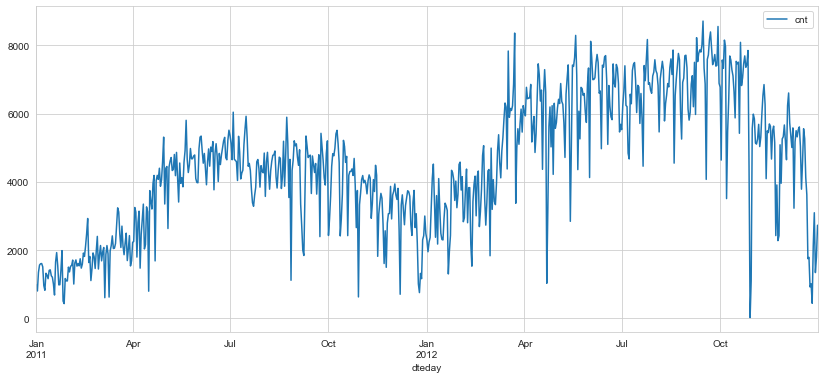

In [20]:
time_series = copy.deepcopy(df[['dteday', 'cnt']])
time_series.index = pd.to_datetime(time_series['dteday'])
time_series = time_series.drop(['dteday'], axis=1)

time_series.plot(figsize=(14,6))
plt.show()

График ряда показывает на наличие возрастающего тренда, наличие сезонной компоненты в один год. Ряд нестационарен, дисперсия ряда растет с увеличением времени.

Подтвердим гипотезу о нестационарности ряда и проводем его STL-декомпозицию.

Критерий стационарности Дики-Фуллера: 0.34274344033921944


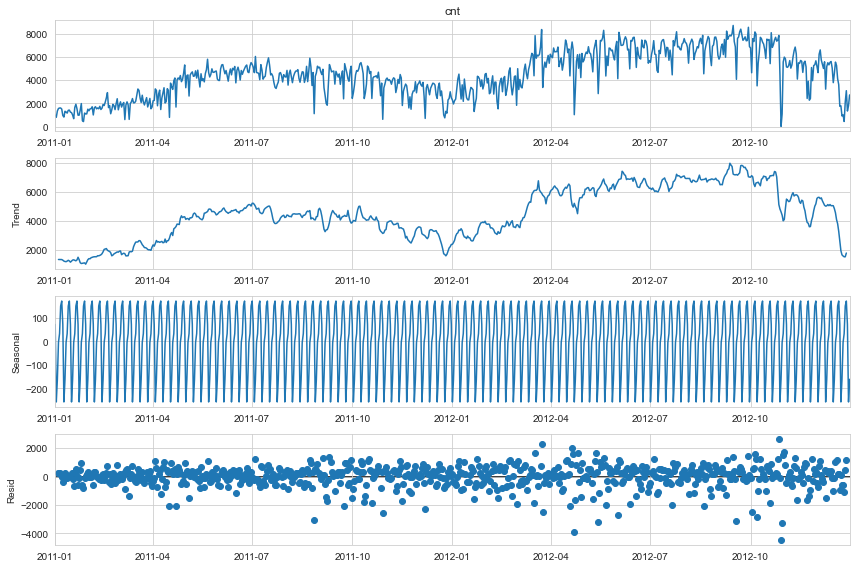

In [21]:
print('Критерий стационарности Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(time_series['cnt'])[1]))
decomp_viz = sm.tsa.seasonal_decompose(time_series['cnt'])
fig = decomp_viz.plot()
fig.set_size_inches((12, 8))
fig.tight_layout()
plt.show()

Попытаемся стабилизировать дисперсию с помощью преобразования Бокса-Кокса

Оптимальное значение параметра преобразования Бокса-Кокса: 0.8835131983317188
Критерий стационарности Дики-Фуллера : 0.31806241777971245


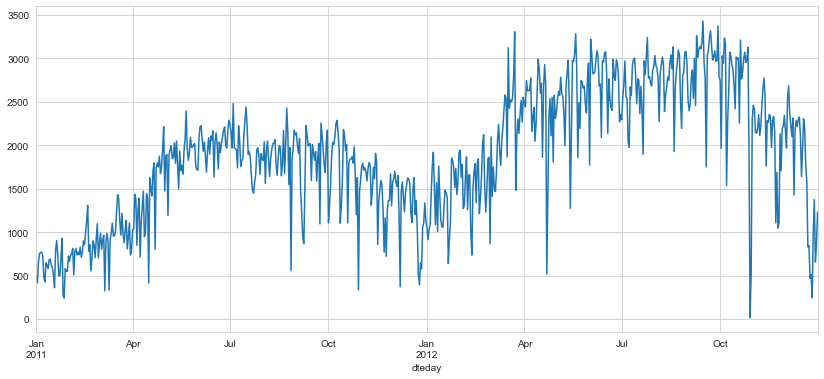

In [22]:
time_series['cnt_box'], lmbda = sts.boxcox(time_series['cnt'])
time_series['cnt_box'].plot(figsize=(14,6))
print('Оптимальное значение параметра преобразования Бокса-Кокса: {}'.format(lmbda))
print('Критерий стационарности Дики-Фуллера : {}'.format(sm.tsa.stattools.adfuller(time_series['cnt_box'])[1]))

Очевидно что ряд все еще не стционарен, проведем обычное дифференцирование, после чего снова проверим на стационарность

Критерий стационарности  Дики-Фуллера: 1.4496503572099664e-21


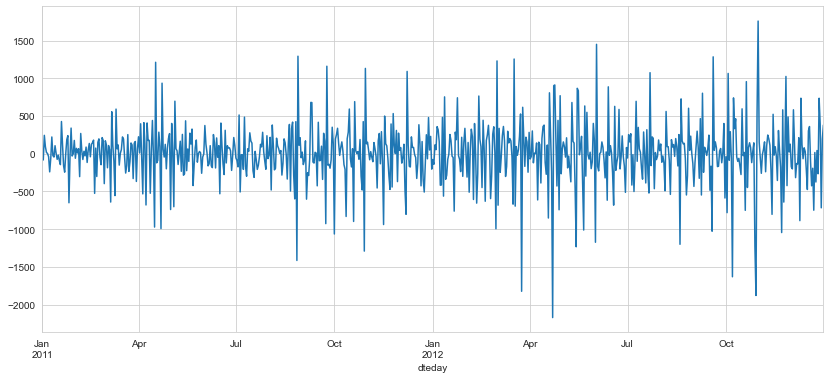

In [23]:
time_series['cnt_box_diff'] = time_series['cnt_box'] - time_series['cnt_box'].shift(1)
print('Критерий стационарности  Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(time_series['cnt_box_diff'][1:])[1]))
time_series['cnt_box_diff'].plot(figsize=(14, 6))
plt.show()

Критерий стационарности Дики-Фуллера: 1.4496503572099664e-21


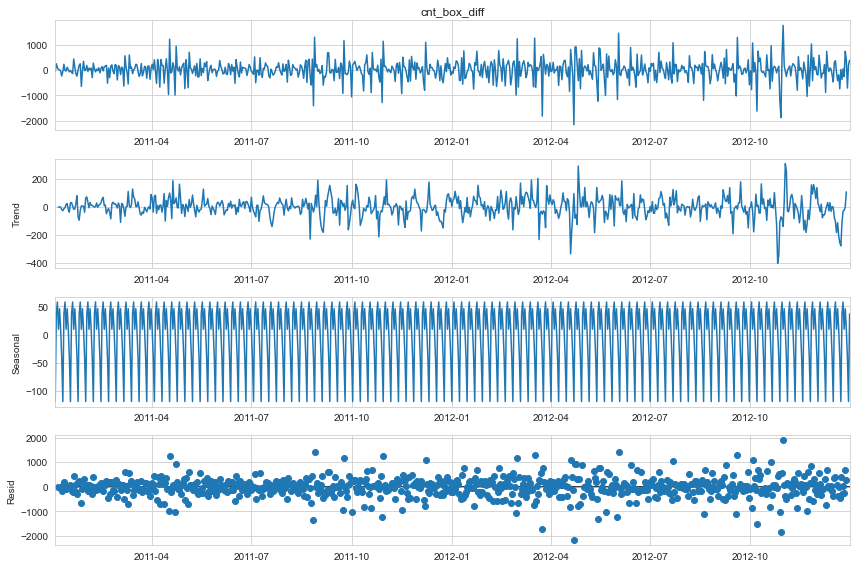

In [24]:
print('Критерий стационарности Дики-Фуллера: {}'.format(sm.tsa.stattools.adfuller(time_series['cnt_box_diff'][1:])[1]))
diff_decomp_viz = sm.tsa.seasonal_decompose(time_series['cnt_box_diff'][1:])
diff_fig = diff_decomp_viz.plot()
diff_fig.set_size_inches((12, 8))
diff_fig.tight_layout()
plt.show()

Теперь ряд стационарен

Построим график PACF и подберем p (Не будем строить график ACF и подбирать значение для q т.к. не планируем включать дисперсию остатков в итоговую модель)

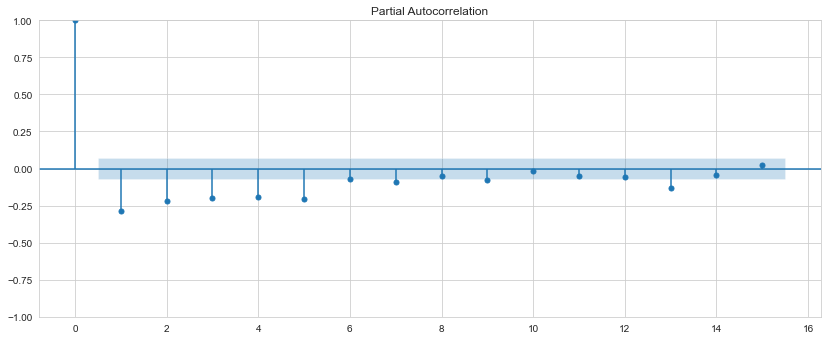

In [25]:
plt.figure(figsize = (14, 12))

ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(time_series['cnt_box_diff'][1:].values.squeeze(), lags=15, ax=ax,)
plt.show()

Введем функцию для обратного преобразования Бокса-Кокса

In [26]:
def inv_boxcox(y, lmbda):
    if lmbda == 0:
        return np.exp(y)
    else:
        return np.exp(np.log(y * lmbda + 1) / lmbda)

Видно что значимыми являются первые 5 временных лагов.

Построим модель ARIMA с p=5 и d=1. Выведем график предсказываемых значений.

ARIMA(p=5, d=1, q=0, P=1, D=0, Q=0) aic: 10668.64714952228


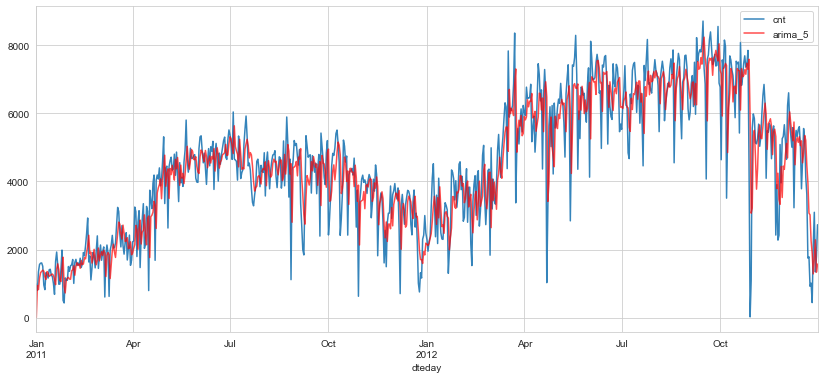

In [27]:
arima_model_5 = sm.tsa.statespace.SARIMAX(time_series['cnt_box'], order=(5, 1, 0)).fit()
print('ARIMA(p=5, d=1, q=0, P=1, D=0, Q=0) aic: {}'.format(arima_model_5.aic))

time_series['arima_5'] = inv_boxcox(arima_model_5.fittedvalues, lmbda)
plt.figure(figsize=(14, 6))
time_series['cnt'].plot(alpha=0.9)
time_series['arima_5'].plot(color='r', alpha=0.7)
plt.legend()
plt.show()

Теперь попробуем построить модель ARIMA с p=1 и d=1. Выведем график предсказываемых значений.

ARIMA(p=1, d=1, q=0, P=1, D=0, Q=0) aic: 10783.457487699196


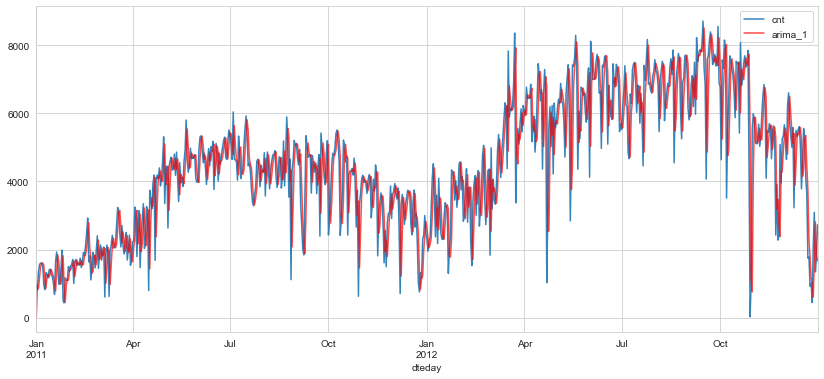

In [28]:
arima_model_1 = sm.tsa.statespace.SARIMAX(time_series['cnt_box'], order=(1, 1, 0)).fit()
print('ARIMA(p=1, d=1, q=0, P=1, D=0, Q=0) aic: {}'.format(arima_model_1.aic))

time_series['arima_1'] = inv_boxcox(arima_model_1.fittedvalues, lmbda)
plt.figure(figsize=(14, 6))
time_series['cnt'].plot(alpha=0.9)
time_series['arima_1'].plot(color='r', alpha=0.7)
plt.legend()
plt.show()

Видно, что при использовании лага в 1 день вместо 5 не произошло значительного уменьшения точности модели, поэтому добавим в модель лаг длинной в 1 день.

Также в модель был добавлен сезонный лаг в один год.

In [29]:
X['lag'] = df['cnt'].shift(1).values
X['lag_y'] = None
X['lag_y'][(df['dteday'].dt.day != 29) | (df['dteday'].dt.month != 2)] = df[
    (df['dteday'].dt.day != 29) | (df['dteday'].dt.month != 2)]['cnt'].shift(365).values
X.fillna(0, inplace=True)
X.sample(10, random_state=42)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,week,lag,lag_y
703,4,1,12,0,2,1,1,0.475833,0.469054,0.733750,0.174129,49,6234.0,3485.0
33,1,0,2,0,4,1,1,0.186957,0.177878,0.437826,0.277752,5,1526.0,0.0
300,4,0,10,0,5,1,2,0.330833,0.318812,0.585833,0.229479,43,2659.0,0.0
456,2,1,4,0,0,0,2,0.425833,0.417287,0.676250,0.172267,13,6235.0,2227.0
633,4,1,9,0,2,1,1,0.550000,0.544179,0.570000,0.236321,39,7436.0,5010.0
557,3,1,7,0,3,1,1,0.716667,0.650271,0.633333,0.151733,28,6290.0,4086.0
39,1,0,2,0,3,1,2,0.134783,0.144283,0.494783,0.188839,6,1530.0,0.0
356,1,0,12,0,5,1,1,0.373333,0.377513,0.686250,0.274246,51,3068.0,0.0
559,3,1,7,0,5,1,2,0.731667,0.667933,0.485833,0.080850,28,7446.0,4342.0
514,2,1,5,0,2,1,1,0.722500,0.672992,0.684583,0.295400,22,6043.0,4788.0


In [30]:
print('Add lag estimation\n')
base_lag_results = make_estimation(clf=LinearRegression(), X=X, y=y)

print("\nLag vs Linear model\n")
make_comparisons(base_lag_results, base_results)

Add lag estimation

Model MAE: 621.7276
Model R2: 0.4558

Lag vs Linear model

MAE changes: -156.5409
R2 changes: +0.3104




Добавление временного лага значительно повысило качество предсказаний модели.

### 2. Проверка допущений применения классической модели регрессии

#### 2.1 Проверка на наличие пропусков в данных

Проверим что набор данных не содержит пропусков

In [31]:
X.join(pd.DataFrame(y)).isnull().any()

season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
week          False
lag           False
lag_y         False
cnt           False
dtype: bool

In [32]:
X.join(pd.DataFrame(y)).isna().any()

season        False
yr            False
mnth          False
holiday       False
weekday       False
workingday    False
weathersit    False
temp          False
atemp         False
hum           False
windspeed     False
week          False
lag           False
lag_y         False
cnt           False
dtype: bool

#### 2.2 Проверка на наличие выбросов в данных

Построим гистограммы распределения данных для числовых и категориальных переменных.

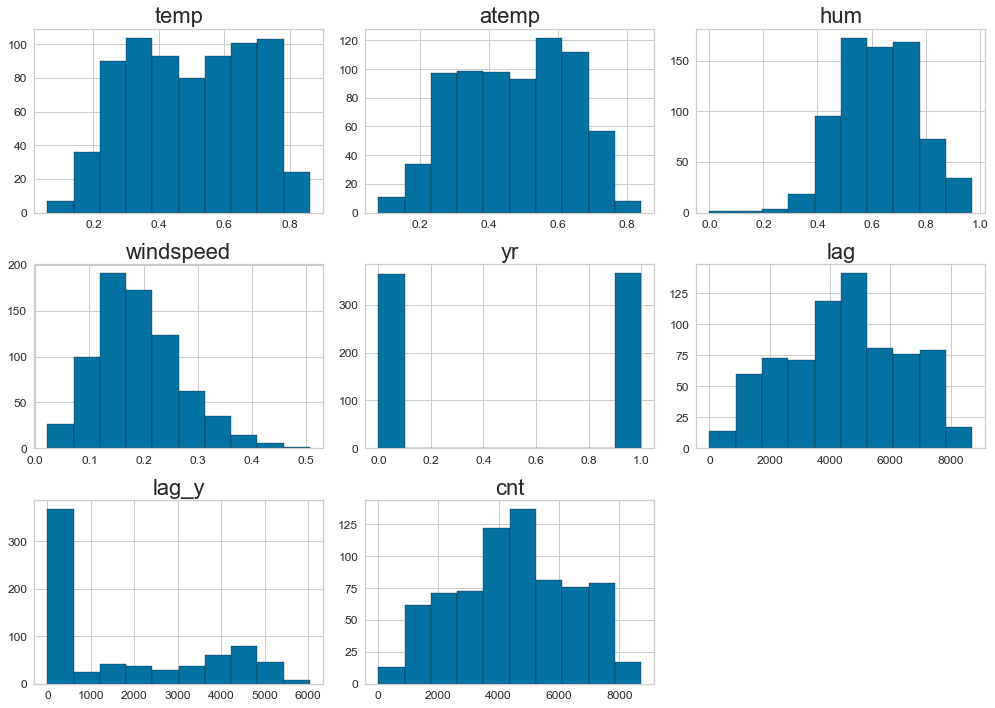

In [79]:
numeric_cols = ['temp', 'atemp', 'hum', 'windspeed', 'yr', 'lag', 'lag_y', 'cnt']
X.join(pd.DataFrame(y))[numeric_cols].hist(figsize=(14,10), ec="k")
plt.tight_layout()

params = {'axes.titlesize':'22',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12'}
matplotlib.rcParams.update(params)
plt.show()

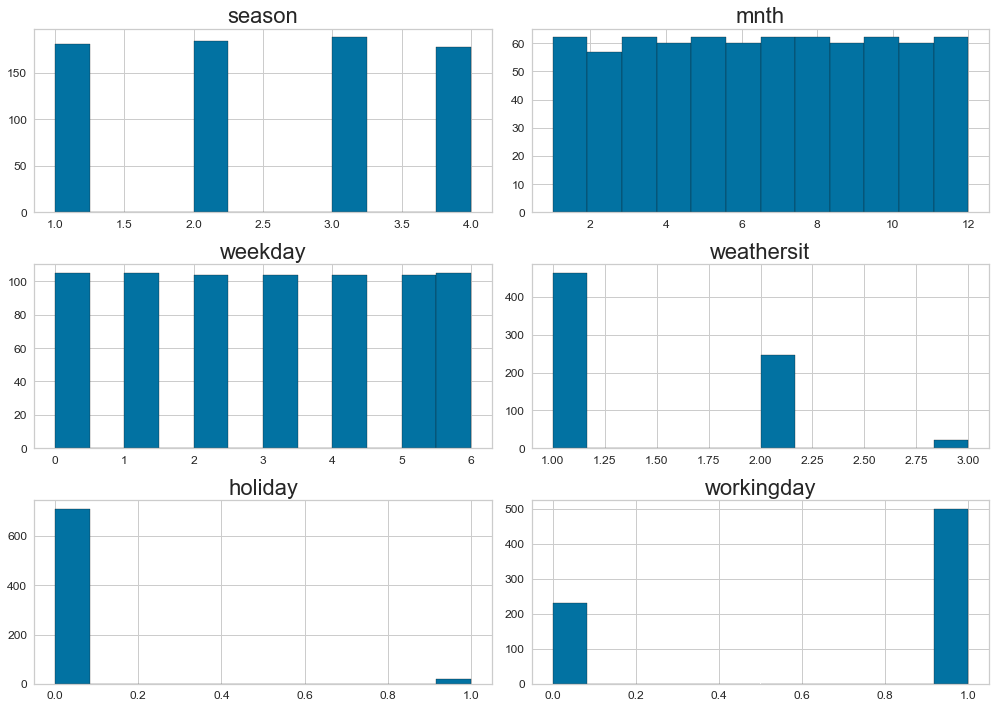

In [80]:
discret_cols = ['season', 'mnth', 'weekday', 'weathersit', 'holiday', 'workingday']
X.join(pd.DataFrame(y))[discret_cols].hist(figsize=(14,10), bins=12, ec="k")
plt.tight_layout()

params = {'axes.titlesize':'22',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12'}
matplotlib.rcParams.update(params)
plt.show()

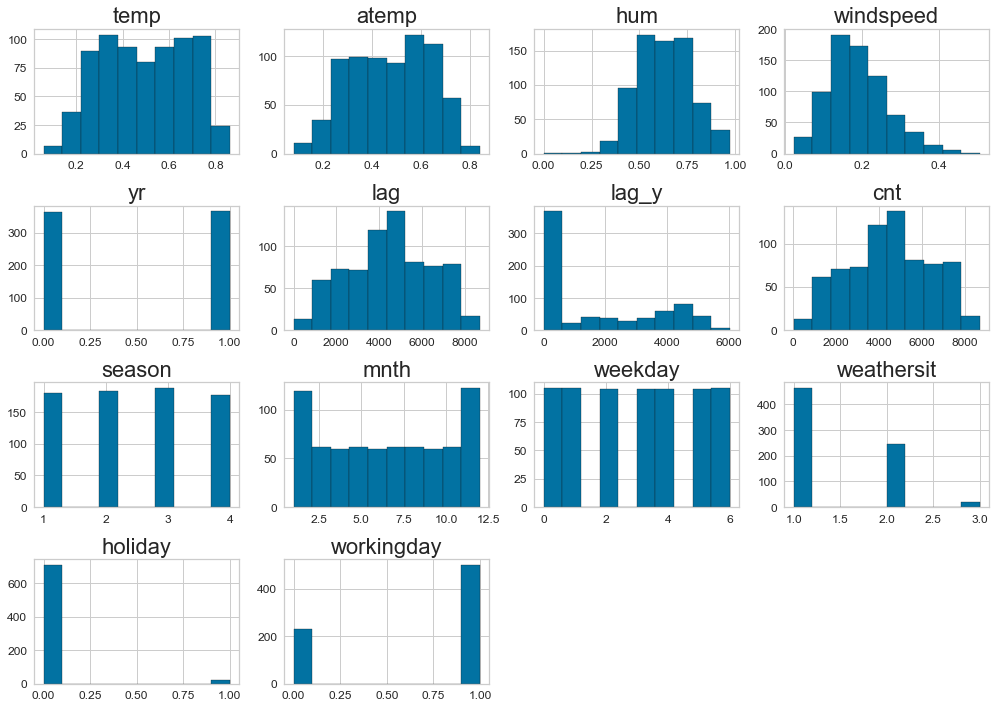

In [81]:
X.join(pd.DataFrame(y))[numeric_cols + discret_cols].hist(figsize=(14,10), ec="k")
plt.tight_layout()

params = {'axes.titlesize':'24',
          'xtick.labelsize':'12',
          'ytick.labelsize':'12'}
matplotlib.rcParams.update(params)
plt.show()

Изучив гистограммы распределения признаков мы можем сказать, что данные не содержат выбросов.

Глядя на гистограммы распределения категориальных признаков можно отметить, что переменные *season*, *mnth*, и *weekday* имеют распределение близкое к равномерному (что должнео наблюдаться в случае сбора данных за два полных года), рабочие и выходные дни соотносятся примерно как 5 к 2, также можно отметить небольшую долю праздничных дней в общей выборке, что также соответсвует их ожидаемому распределению.

#### 2.3 Проведем корреляционный анализ данных

Построим корреляционную матрицу Пирсона для набора данных

In [35]:
corr_pirson = X.join(pd.DataFrame(y)).corr(method='pearson')
corr_pirson.style.background_gradient(cmap='coolwarm').set_precision(4)

,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,week,lag,lag_y,cnt
season,1.0000,-0.0018,0.8314,-0.0105,-0.0031,0.0125,0.0192,0.3343,0.3429,0.2054,-0.2290,0.8154,0.4127,0.1914,0.4061
yr,-0.0018,1.0000,-0.0018,0.0080,-0.0055,-0.0020,-0.0487,0.0476,0.0461,-0.1107,-0.0118,-0.0023,0.5665,0.8659,0.5667
mnth,0.8314,-0.0018,1.0000,0.0192,0.0095,-0.0059,0.0435,0.2202,0.2275,0.2222,-0.2075,0.9667,0.2919,0.1573,0.2800
holiday,-0.0105,0.0080,0.0192,1.0000,-0.1020,-0.2530,-0.0346,-0.0286,-0.0325,-0.0159,0.0063,0.0205,-0.0513,-0.0166,-0.0683
weekday,-0.0031,-0.0055,0.0095,-0.1020,1.0000,0.0358,0.0311,-0.0002,-0.0075,-0.0522,0.0143,0.0023,0.0499,-0.0101,0.0674
workingday,0.0125,-0.0020,-0.0059,-0.2530,0.0358,1.0000,0.0612,0.0527,0.0522,0.0243,-0.0188,-0.0159,-0.0126,0.0089,0.0612
weathersit,0.0192,-0.0487,0.0435,-0.0346,0.0311,0.0612,1.0000,-0.1206,-0.1216,0.5910,0.0395,0.0439,-0.1179,-0.0843,-0.2974
temp,0.3343,0.0476,0.2202,-0.0286,-0.0002,0.0527,-0.1206,1.0000,0.9917,0.1270,-0.1579,0.2164,0.6223,0.2748,0.6275
atemp,0.3429,0.0461,0.2275,-0.0325,-0.0075,0.0522,-0.1216,0.9917,1.0000,0.1400,-0.1836,0.2242,0.6240,0.2711,0.6311
hum,0.2054,-0.1107,0.2222,-0.0159,-0.0522,0.0243,0.5910,0.1270,0.1400,1.0000,-0.2485,0.2367,0.0049,-0.0753,-0.1007


Глядя на матрицу корреляции можно выделить сильную взаимосвязь между следующими переменными:
- *temp* и *atemp*
- *week*, *season* и *mnth*

Исключим из модели переменную *temp*, а также переменные *mnth* и *week* т.к. они имеют наименьшую корреляцию с *cnt*.
Помимо этого, исключим переменную *weekday*  т.к. наиболее важная часть инфомрации (является ли день выходным) хранящейся 
в этой переменной уже содержиться в *workingday*.

In [36]:
X_dropped = X.drop( ['temp', 'mnth', 'week', 'weekday', ], axis=1)

print('Drop variables estimation\n')
drop_results = make_estimation(clf=LinearRegression(), X=X_dropped, y=y)

print("\nDrop model vs Linear model\n")
make_comparisons(drop_results, base_lag_results)

Drop variables estimation

Model MAE: 603.7923
Model R2: 0.4759

Drop model vs Linear model

MAE changes: -17.9352
R2 changes: +0.0201




Видно, что исключение переменных повысило качество модели

Помимо это можно заметить, что yr оказывает сильное влияние на cnt

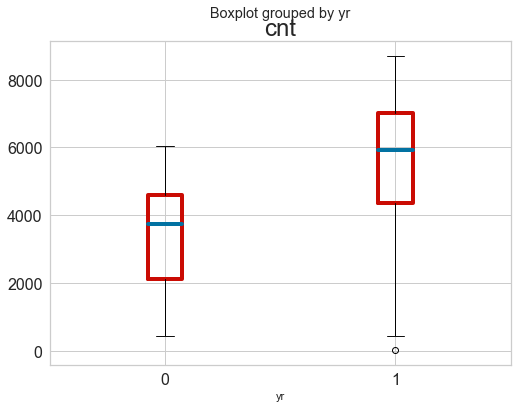

In [86]:
boxprops = dict(linestyle='-', linewidth=4, color='r')
medianprops = dict(linestyle='-', linewidth=4, color='b')
X.join(pd.DataFrame(y)).boxplot(column=['cnt'], by='yr', figsize=(8, 6),
                boxprops=boxprops,
                medianprops=medianprops)

plt.show()

Действительно, можно сказать что в 1 году среднее число сданных в прокатв велосипедов значительно увеличилось. 
Это может быть вызванно ростом популярности сервиса. При использовании этой переменной следует, что хотя она 
может быть полезна для прогнозирования в данном диапазоне лет, алгоритм должен будет существенно экстраполировать, 
чтобы предсказать, как она повлияет на будущие даты, 
что может сделать эту переменную менее надежным предиктором для другого временного периода.

#### 2.4 Проверка на линейную зависимость между предикторами и зависимой переменной

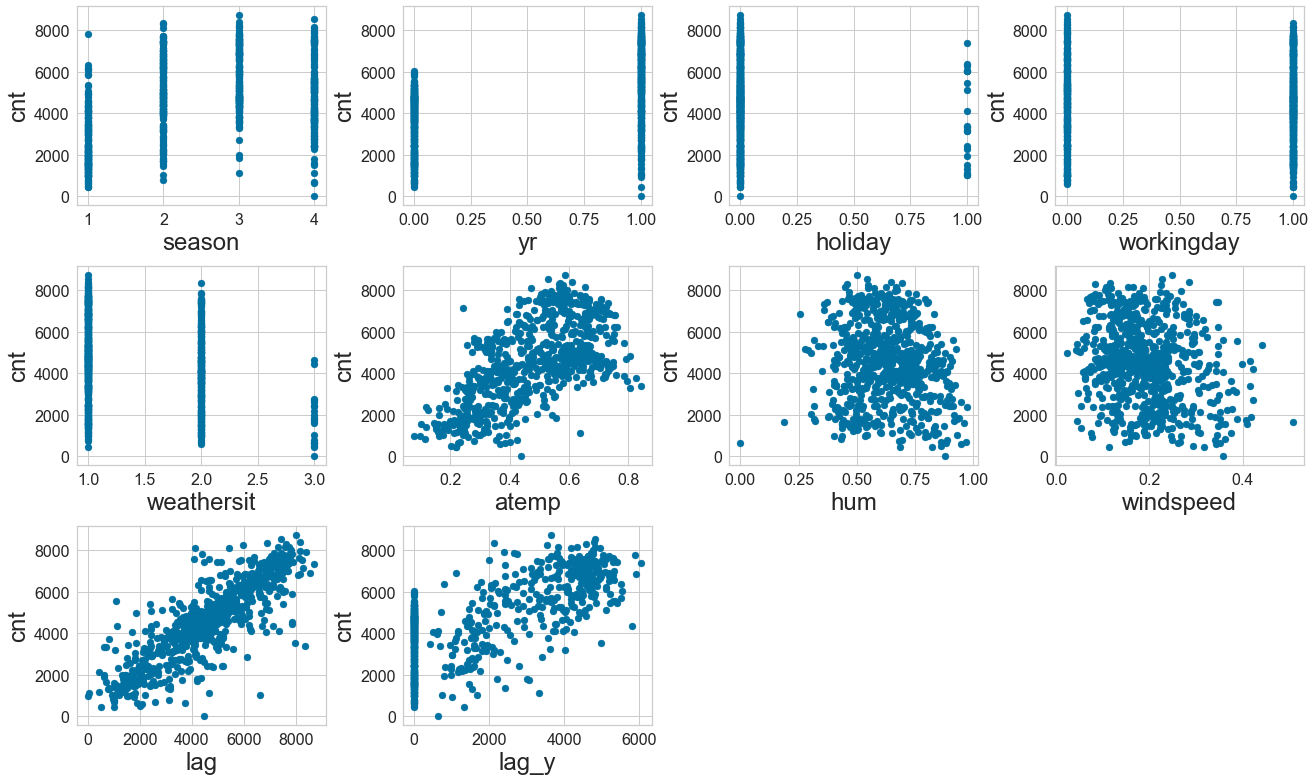

In [103]:
fig = plt.figure(figsize=(22,18))

for n, x_col in enumerate(X_dropped.columns):
    plt.subplot(4, 4, n + 1)
    plt.scatter(X_dropped[x_col], y)
    plt.subplots_adjust(wspace=0.31, hspace=0.31)
    plt.xlabel(x_col, fontsize=24)
    plt.ylabel('cnt', fontsize=24)

Исходня из построенных графиков можно отметить:
- Сильную положительную корреляцию целевой переменной с переменными *yr*, *lag* и *atemp*
- Довольно слабую отрицательную корреляцию целевой переменной с *hun* и *windspeed*
- Слабую отрицательную корреляцию *cnt* с бинарными переменными *workingday* и *holiday*
- Отсутсвия явной корреляции целевой переменной с численно закодироваными категориальными переменными *weathersit* и *season*

Используем OneHoeEncoding, для кодирования переменных *season* и *weathersit*.

In [39]:
X_encoded = pd.get_dummies(X_dropped, columns=['season', 'weathersit'])

print('OneHotEncoding estimation\n')
encode_results = make_estimation(clf=LinearRegression(), X=X_encoded, y=y, cv=5)

print("\nOneHot + Drop model vs Linear model\n")
make_comparisons(encode_results, base_lag_results)

print("\nOneHot + Drop model vs Drop Linear model\n")
make_comparisons(encode_results, drop_results)

OneHotEncoding estimation

Model MAE: 574.9638
Model R2: 0.5219

OneHot + Drop model vs Linear model

MAE changes: -46.7637
R2 changes: +0.0661



OneHot + Drop model vs Drop Linear model

MAE changes: -28.8285
R2 changes: +0.046




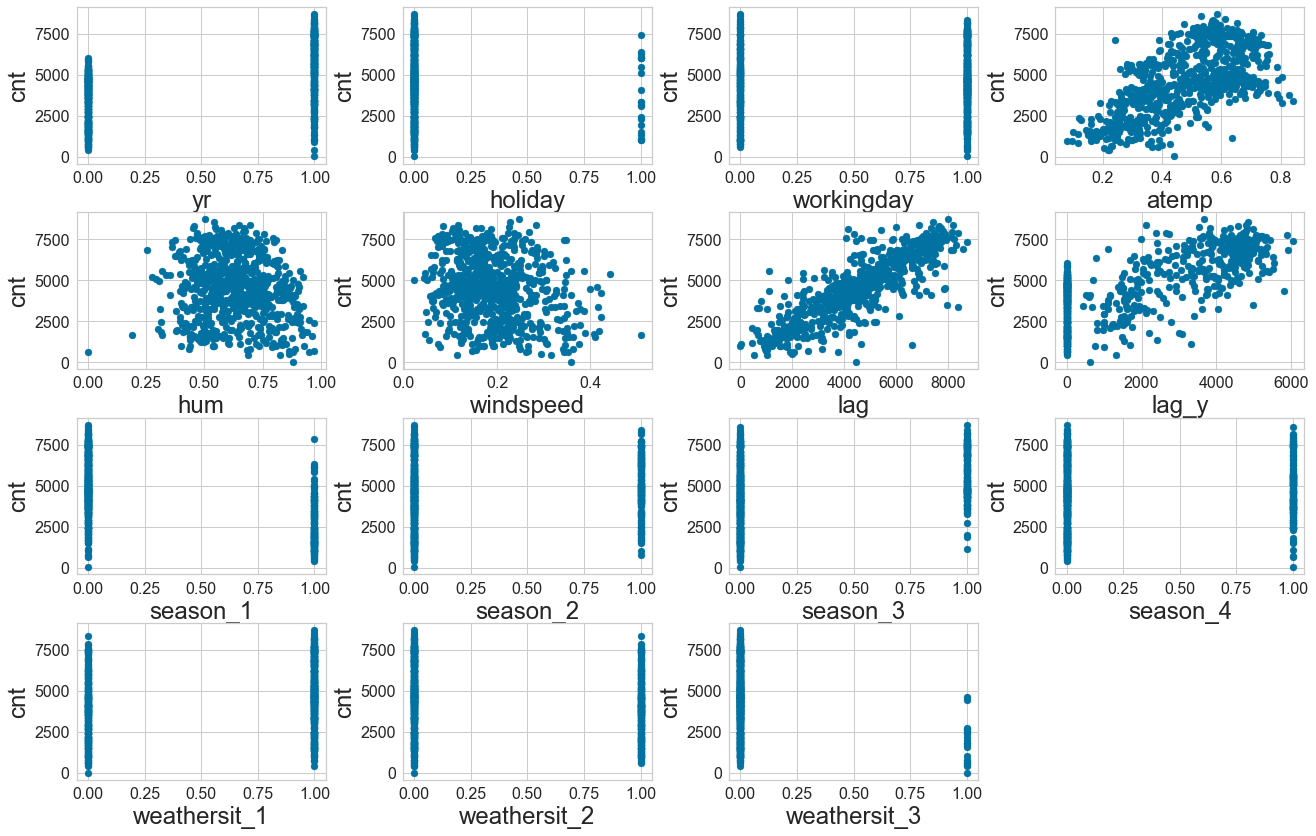

In [106]:
fig = plt.figure(figsize=(22,18))

for n, x_col in enumerate(X_encoded.columns):
    plt.subplot(5, 4, n + 1)
    plt.scatter(X_encoded[x_col], y)
    plt.subplots_adjust(wspace=0.31, hspace=0.31)
    plt.xlabel(x_col, fontsize=24)
    plt.ylabel('cnt', fontsize=24)

#### 2.5 Проверим что остатки модели подчиняются нормальному распределению

Проведем разбиение на обучающую и валидационную выборки

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, train_size=0.8, random_state=42)

Построим график QQ-plot и гистограмму распределения для остатков модели линейной регрессии

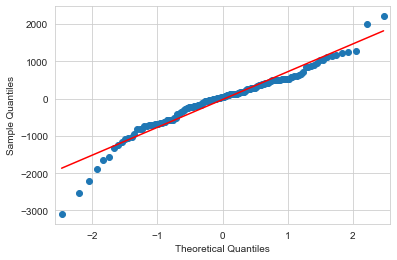

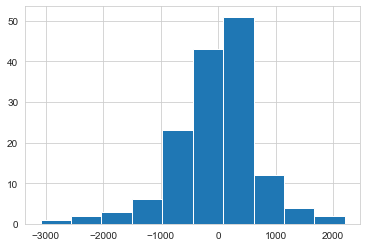

Гипотеза о номарльности может быть отвергнута на 5% уровне значимости


In [42]:
diff_base_model = y_test - LinearRegression().fit(X_train, y_train).predict(X_test)
sm.qqplot(diff_base_model, line="s")
plt.show()
diff_base_model.hist()
plt.show()

k2, p = sts.normaltest(diff_base_model)
alpha = 0.05
if p < alpha: 
    print("Гипотеза о номарльности может быть отвергнута на 5% уровне значимости")
else:
    print("Гипотеза о номарльности не может быть отвергнута на 5% уровне значимости")

Полученные остатки близки к нормальным, хотя и имеют довольно сильные отклонения на хвостах распределения.


Тест на нормальность показал что мы можем отвергнуть гипотезу о нормальности на 5% уровне значимости, однако т.к. мы имеем
достаточно большой набор данных, этот критерйи не обязательно должен выполняться.

#### 2.6 Гомоскедастичность остатков

Выведем график зависимости остатков от зависимой переменной

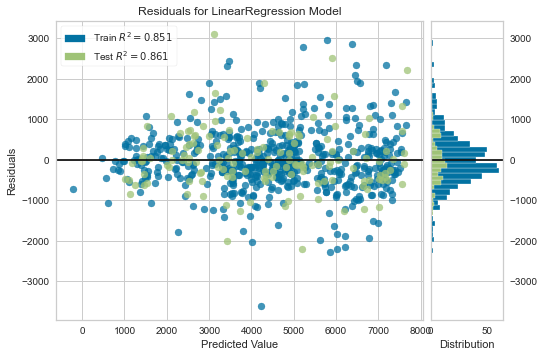

In [43]:
from yellowbrick.regressor import ResidualsPlot

vis = ResidualsPlot(LinearRegression())
vis.fit(X_train, y_train)
vis.score(X_test, y_test)
vis.poof()
plt.show()

Глядя на график можно сказать, что распределение остатков не зависит от значений прогнозируемой переменной

#### 2.7 Предсказание модели линейной регрессии

In [44]:
def reg_model_estimation(clf, X, y, score_round_ord=4,
               scoring={'MAE': make_scorer(mean_absolute_error, greater_is_better=True),
                        'R2': make_scorer(r2_score, greater_is_better=True)}):
    reg_scores = {}
    for score_name in scoring:
        score_key = 'test_' + score_name
        reg_scores[score_key] = scoring[score_name](clf, X_test, y_test)
        print('Model {}: {}'.format(score_name, round(reg_scores[score_key], score_round_ord)))
    
    return reg_scores

Linear regression cross_val train estimation

Model MAE: 549.4971
Model R2: 0.8365

Linear regression test estimation

Model MAE: 534.5278
Model R2: 0.8612


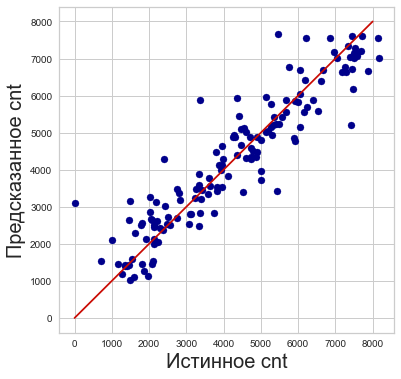

In [45]:
print('Linear regression cross_val train estimation\n')
baseline_cross_results = make_estimation(clf=LinearRegression(), X=X_train, y=y_train, cv=5)

print('\nLinear regression test estimation\n')
baseline_clf = LinearRegression().fit(X_train, y_train)
baseline_res = reg_model_estimation(clf=baseline_clf, X=X_test, y=y_test)

plt.figure(figsize=(6, 6))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue') 
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.show()

### 3 Выбор модели

#### 3.1 Выбор регрессионной модели

In [46]:
def reg_model_grid_estimation(classifier, params_grid, X, y, scoring='neg_mean_absolute_error', cv=5):
    grid_cv = GridSearchCV(classifier, params_grid, scoring=scoring, cv=cv)
    grid_cv.fit(X, y)
    return grid_cv

In [47]:
def estimate_clf(clf, clf_name, params_grid, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test, cv=5):
    grid_res = reg_model_grid_estimation(clf, params_grid, X_train, y_train, cv=cv)
    clf_best_par = clf.set_params(**grid_res.best_params_)
    
    print('{} cross_val train estimation\n'.format(clf_name))
    cross_res = make_estimation(clf=clf_best_par, X=X_train, y=y_train, cv=cv)

    print('\n{} test estimation\n'.format(clf_name))
    clf = clf_best_par.fit(X_train, y_train)
    res = reg_model_estimation(clf=clf_best_par, X=X_test, y=y_test)

    print('\n{} vs Linear regression\n'.format(clf_name))
    make_comparisons(res, baseline_res)
    
    return grid_res, clf, cross_res, res

Elastic net cross_val train estimation

Model MAE: 549.483
Model R2: 0.8367

Elastic net test estimation

Model MAE: 534.4949
Model R2: 0.8609

Elastic net vs Linear regression

MAE changes: -0.0329
R2 changes: -0.0003




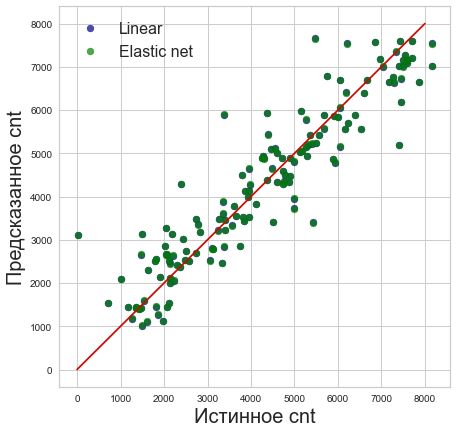

In [48]:
elastic_parameters_grid = {
    'alpha': [0.00001, 0.001, 0.1,],
    'l1_ratio': [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
}

elastic_net_grid_res, elastic_net_clf, elastic_net_cross_res, elastic_net_res = estimate_clf(
    ElasticNet(random_state=42), 'Elastic net', elastic_parameters_grid)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, elastic_net_clf.predict(X_test), color='green', alpha=0.7, label='Elastic net')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

Decision tree cross_val train estimation

Model MAE: 654.4925
Model R2: 0.7613

Decision tree test estimation

Model MAE: 577.327
Model R2: 0.8327

Decision tree vs Linear regression

MAE changes: +42.7991
R2 changes: -0.0285




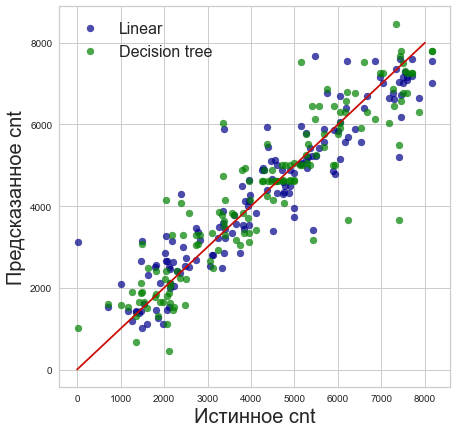

In [49]:
decision_tree_parameters_grid = {
    'criterion': ['squared_error', 'absolute_error', 'poisson'],
    'splitter': ['best', 'random'],
    'max_depth': [5, 10, 100, 150, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
}

decision_tree_grid_res, decision_tree_clf, decision_tree_cross_res, decision_tree_res = estimate_clf(
    DecisionTreeRegressor(random_state=42), 'Decision tree', decision_tree_parameters_grid)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, decision_tree_clf.predict(X_test), color='green', alpha=0.7, label='Decision tree')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

#### 3.2 Полиномиальная и сплайновая регрессия

Polynomial Elastic net cross_val train estimation

Model MAE: 520.7287
Model R2: 0.8362

Polynomial Elastic net test estimation

Model MAE: 449.9427
Model R2: 0.9129

Polynomial Elastic net vs Linear regression

MAE changes: -84.5851
R2 changes: +0.0517




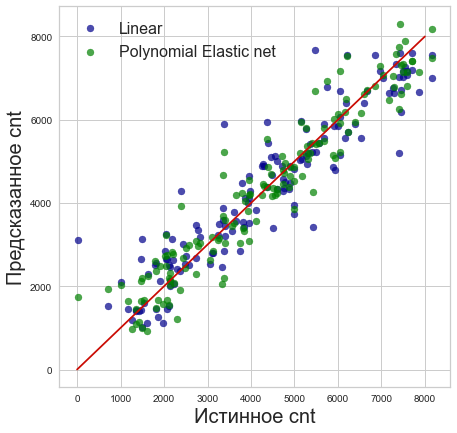

In [50]:
poly_parameters_grid = {
    'solver__alpha': [0.00001, 0.001, 0.1,],
    'poly__degree': [2, 3, 4],
}

poly_pipeline = Pipeline([('poly', PolynomialFeatures()), ('solver', Ridge(random_state=42))])
poly_grid_res, poly_clf, poly_cross_res, poly_res = estimate_clf(
    poly_pipeline, 'Polynomial Elastic net', poly_parameters_grid, cv=5)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, poly_clf.predict(X_test), color='green', alpha=0.7, label='Polynomial Elastic net')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

Spline Elastic net cross_val train estimation

Model MAE: 477.0019
Model R2: 0.8733

Spline Elastic net test estimation

Model MAE: 446.5475
Model R2: 0.9024

Spline Elastic net vs Linear regression

MAE changes: -87.9803
R2 changes: +0.0412




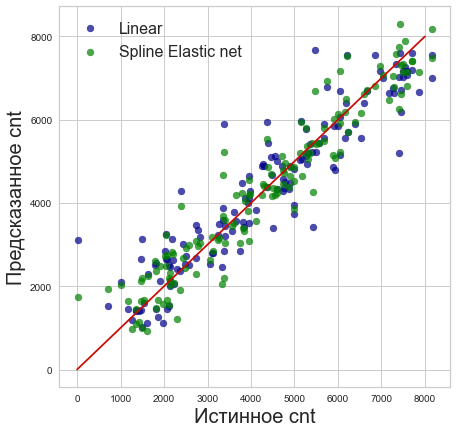

In [51]:
spline_parameters_grid = {
    'solver__alpha': [0.00001, 0.001, 0.1,],
    'spline__degree': [2, 3, 4],
    'spline__n_knots': [2, 3, 4, 5, 6]
}

spline_pipeline = Pipeline([('spline', SplineTransformer()), ('solver', Ridge(random_state=42))])
spline_grid_res, spline_clf, spline_cross_res, spline_res = estimate_clf(
    spline_pipeline, 'Spline Elastic net', spline_parameters_grid, cv=5)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, poly_clf.predict(X_test), color='green', alpha=0.7, label='Spline Elastic net')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

#### 3.3 Ансамблевые модели

Random Forest cross_val train estimation

Model MAE: 514.0426
Model R2: 0.849

Random Forest test estimation

Model MAE: 488.5825
Model R2: 0.8834

Random Forest vs Linear regression

MAE changes: -45.9454
R2 changes: +0.0222




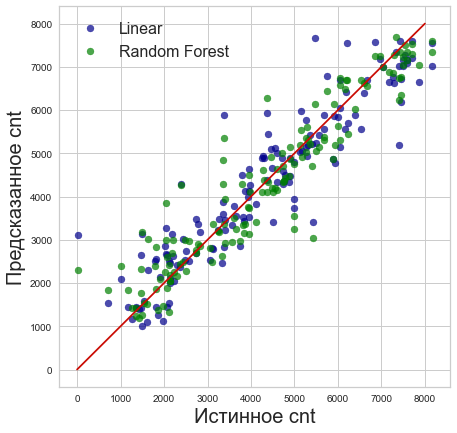

In [52]:
random_forest_parameters_grid = {
    'n_estimators': [10, 100, 1000],
    'max_depth': [5, 10, 100],
}

rf_grid_res, rf_clf, rf_cross_res, rf_res = estimate_clf(
    RandomForestRegressor(random_state=42), 'Random Forest', random_forest_parameters_grid, cv=5)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, rf_clf.predict(X_test), color='green', alpha=0.7, label='Random Forest')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

Ada boost cross_val train estimation

Model MAE: 473.3583
Model R2: 0.8736

Ada boost test estimation

Model MAE: 445.1976
Model R2: 0.9021

Ada boost vs Linear regression

MAE changes: -89.3302
R2 changes: +0.0409




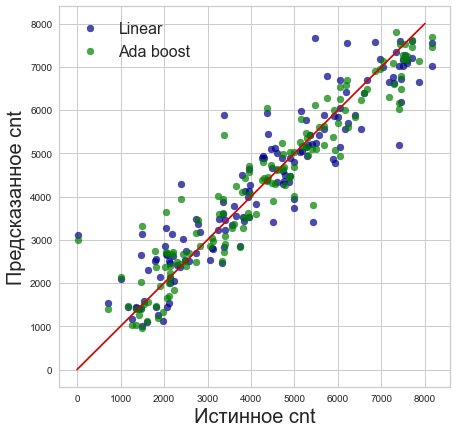

In [53]:
ada_boost_parameters_grid = {
    'base_estimator': [elastic_net_clf,
                       decision_tree_clf,
                       poly_clf,
                       spline_clf,
                      ],
    'n_estimators': [5, 10, 20],
    'learning_rate': [0.01, 1.0],
    'loss': ['linear', 'square'],
}

ada_grid_res, ada_clf, ada_cross_res, ada_res = estimate_clf(
    AdaBoostRegressor(random_state=42), 'Ada boost', ada_boost_parameters_grid, cv=5)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, ada_clf.predict(X_test), color='green', alpha=0.7, label='Ada boost')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

Bagging cross_val train estimation

Model MAE: 537.9903
Model R2: 0.8499

Bagging test estimation

Model MAE: 505.4286
Model R2: 0.8848

Bagging vs Linear regression

MAE changes: -29.0992
R2 changes: +0.0236




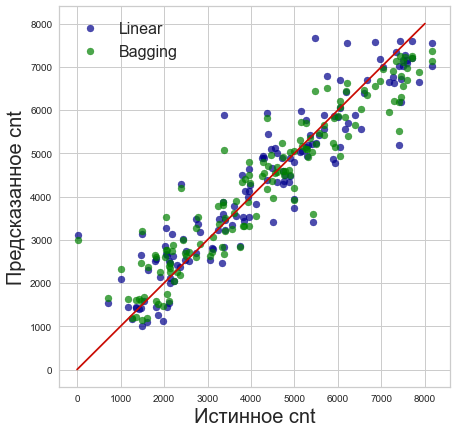

In [54]:
bagging_parameters_grid = {
    'base_estimator': [elastic_net_clf,
                       decision_tree_clf,
                       poly_clf,
                       spline_clf,
                      ],
    'n_estimators': [5, 10, 20],
    'max_samples': [0.1, 1, 10],
    'max_features': [0.1, 1, 10]
}

bag_grid_res, bag_clf, bag_cross_res, bag_res = estimate_clf(
    BaggingRegressor(random_state=42), 'Bagging', bagging_parameters_grid, cv=5)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', alpha=0.7, label='Linear') 
plt.scatter(y_test, bag_clf.predict(X_test), color='green', alpha=0.7, label='Bagging')
plt.plot([0, 8000], [0, 8000], color='r') # рисуем прямую, на которой предсказания и настоящие значения совпадают
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

#### 3.4 Нейросеть

Напишем функцию для оценки $R^{2}$ в процессе обучения нейросети

In [55]:
from keras import backend as K

def R2(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

Создадим нейронную сеть с 2 скрытыми слоями по 400 нейронов в каждом и выходным слоем. 
На каждом слое будем использовать *ReLU* функцию активации. После каждого слоя добавим *dropout* регулляризацию с вероятностью
отключения 20%.

In [56]:
keras.utils.set_random_seed(42)
NN = keras.Sequential(name='NN')

units = 400

NN.add(keras.layers.Dense(units, activation='relu', name='Layer1', input_shape=[15]))
NN.add(keras.layers.Dropout(0.2, name='Drop1'))
NN.add(keras.layers.Dense(units, activation='relu', name='Layer2'))
NN.add(keras.layers.Dropout(0.2, name='Drop2'))
NN.add(keras.layers.Dense(units, activation='relu', name='OutputLayer'))
NN.add(keras.layers.Dense(1, activation='relu'))

    
NN.compile(loss='mse', optimizer='adam', metrics=['mae', R2])
NN.summary()

Model: "NN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer1 (Dense)              (None, 400)               6400      
                                                                 
 Drop1 (Dropout)             (None, 400)               0         
                                                                 
 Layer2 (Dense)              (None, 400)               160400    
                                                                 
 Drop2 (Dropout)             (None, 400)               0         
                                                                 
 OutputLayer (Dense)         (None, 400)               160400    
                                                                 
 dense (Dense)               (None, 1)                 401       
                                                                 
Total params: 327,601
Trainable params: 327,601
Non-trainable pa

Проведем 2000 эпох обучения

In [57]:
%%time
history = NN.fit(X_train.to_numpy(), y_train.to_numpy(), epochs=2000,
                 validation_data=(np.array(X_test.to_numpy()), np.array(y_test.to_numpy())))

Epoch 1/2000
19/19 [==============================] - 1s 10ms/step - loss: 4337618.5000 - mae: 1575.6042 - R2: -0.3470 - val_loss: 1298536.0000 - val_mae: 908.6450 - val_R2: 0.6184
Epoch 2/2000
19/19 [==============================] - 0s 5ms/step - loss: 1367002.0000 - mae: 911.7439 - R2: 0.5713 - val_loss: 1539215.2500 - val_mae: 1022.1203 - val_R2: 0.5554
Epoch 3/2000
19/19 [==============================] - 0s 4ms/step - loss: 1245062.8750 - mae: 835.8817 - R2: 0.6495 - val_loss: 1080357.0000 - val_mae: 746.9699 - val_R2: 0.6907
Epoch 4/2000
19/19 [==============================] - 0s 4ms/step - loss: 1147724.0000 - mae: 792.2109 - R2: 0.6686 - val_loss: 1069509.1250 - val_mae: 720.5820 - val_R2: 0.6968
Epoch 5/2000
19/19 [==============================] - 0s 4ms/step - loss: 1095824.8750 - mae: 758.5385 - R2: 0.6958 - val_loss: 1218985.6250 - val_mae: 851.4022 - val_R2: 0.6477
Epoch 6/2000
19/19 [==============================] - 0s 4ms/step - loss: 1026632.4375 - mae: 761.0035 - R

Epoch 47/2000
19/19 [==============================] - 0s 4ms/step - loss: 1063927.6250 - mae: 757.8583 - R2: 0.6949 - val_loss: 1055961.6250 - val_mae: 711.5872 - val_R2: 0.6995
Epoch 48/2000
19/19 [==============================] - 0s 3ms/step - loss: 1043321.8750 - mae: 752.8851 - R2: 0.6706 - val_loss: 1179857.2500 - val_mae: 838.5867 - val_R2: 0.6574
Epoch 49/2000
19/19 [==============================] - 0s 4ms/step - loss: 1174001.6250 - mae: 817.5836 - R2: 0.6637 - val_loss: 1068881.0000 - val_mae: 742.4011 - val_R2: 0.6933
Epoch 50/2000
19/19 [==============================] - 0s 3ms/step - loss: 1080455.8750 - mae: 772.1886 - R2: 0.6732 - val_loss: 1225593.5000 - val_mae: 855.6531 - val_R2: 0.6470
Epoch 51/2000
19/19 [==============================] - 0s 4ms/step - loss: 1118109.1250 - mae: 770.7781 - R2: 0.6838 - val_loss: 1135100.5000 - val_mae: 811.0212 - val_R2: 0.6698
Epoch 52/2000
19/19 [==============================] - 0s 4ms/step - loss: 1017602.4375 - mae: 743.7502 -

Epoch 93/2000
19/19 [==============================] - 0s 3ms/step - loss: 1133032.0000 - mae: 792.5397 - R2: 0.6680 - val_loss: 1076018.3750 - val_mae: 765.7234 - val_R2: 0.6885
Epoch 94/2000
19/19 [==============================] - 0s 4ms/step - loss: 1040488.5625 - mae: 758.2685 - R2: 0.7018 - val_loss: 1046536.0625 - val_mae: 728.1985 - val_R2: 0.7007
Epoch 95/2000
19/19 [==============================] - 0s 3ms/step - loss: 1104507.5000 - mae: 775.1122 - R2: 0.6737 - val_loss: 1034326.6250 - val_mae: 705.5687 - val_R2: 0.7041
Epoch 96/2000
19/19 [==============================] - 0s 3ms/step - loss: 1034489.4375 - mae: 743.5982 - R2: 0.6924 - val_loss: 1196386.2500 - val_mae: 848.6827 - val_R2: 0.6540
Epoch 97/2000
19/19 [==============================] - 0s 4ms/step - loss: 1073148.6250 - mae: 769.6820 - R2: 0.6771 - val_loss: 1086246.8750 - val_mae: 710.0830 - val_R2: 0.6957
Epoch 98/2000
19/19 [==============================] - 0s 4ms/step - loss: 1072969.7500 - mae: 754.6556 -

19/19 [==============================] - 0s 4ms/step - loss: 1087311.8750 - mae: 766.8416 - R2: 0.6848 - val_loss: 1016943.8750 - val_mae: 708.6899 - val_R2: 0.7064
Epoch 139/2000
19/19 [==============================] - 0s 4ms/step - loss: 986791.2500 - mae: 729.0104 - R2: 0.7232 - val_loss: 1080790.3750 - val_mae: 702.2324 - val_R2: 0.6961
Epoch 140/2000
19/19 [==============================] - 0s 3ms/step - loss: 1052755.7500 - mae: 765.5654 - R2: 0.6478 - val_loss: 1145295.3750 - val_mae: 820.6736 - val_R2: 0.6673
Epoch 141/2000
19/19 [==============================] - 0s 4ms/step - loss: 1112120.5000 - mae: 791.9437 - R2: 0.6877 - val_loss: 1149332.6250 - val_mae: 730.3921 - val_R2: 0.6830
Epoch 142/2000
19/19 [==============================] - 0s 4ms/step - loss: 1060903.0000 - mae: 754.5983 - R2: 0.6939 - val_loss: 1017942.3125 - val_mae: 704.7362 - val_R2: 0.7082
Epoch 143/2000
19/19 [==============================] - 0s 3ms/step - loss: 1099772.3750 - mae: 765.0838 - R2: 0.690

Epoch 184/2000
19/19 [==============================] - 0s 4ms/step - loss: 1029461.3750 - mae: 747.1232 - R2: 0.7067 - val_loss: 1007718.3125 - val_mae: 696.7837 - val_R2: 0.7122
Epoch 185/2000
19/19 [==============================] - 0s 4ms/step - loss: 978583.6875 - mae: 730.0239 - R2: 0.7226 - val_loss: 1014588.1875 - val_mae: 687.6016 - val_R2: 0.7115
Epoch 186/2000
19/19 [==============================] - 0s 4ms/step - loss: 994832.0000 - mae: 737.7450 - R2: 0.6994 - val_loss: 1066375.1250 - val_mae: 763.0195 - val_R2: 0.6924
Epoch 187/2000
19/19 [==============================] - 0s 4ms/step - loss: 991338.9375 - mae: 741.4012 - R2: 0.7244 - val_loss: 1020004.5625 - val_mae: 735.0980 - val_R2: 0.7029
Epoch 188/2000
19/19 [==============================] - 0s 4ms/step - loss: 961446.6875 - mae: 715.0126 - R2: 0.7379 - val_loss: 1010113.7500 - val_mae: 705.6232 - val_R2: 0.7100
Epoch 189/2000
19/19 [==============================] - 0s 3ms/step - loss: 990893.3750 - mae: 723.5201 

Epoch 230/2000
19/19 [==============================] - 0s 4ms/step - loss: 957669.2500 - mae: 706.1277 - R2: 0.7159 - val_loss: 989287.7500 - val_mae: 701.6272 - val_R2: 0.7163
Epoch 231/2000
19/19 [==============================] - 0s 4ms/step - loss: 976528.2500 - mae: 717.0094 - R2: 0.7225 - val_loss: 964252.1875 - val_mae: 700.7704 - val_R2: 0.7196
Epoch 232/2000
19/19 [==============================] - 0s 4ms/step - loss: 941264.3125 - mae: 718.2678 - R2: 0.7055 - val_loss: 1002142.5000 - val_mae: 688.1177 - val_R2: 0.7158
Epoch 233/2000
19/19 [==============================] - 0s 3ms/step - loss: 961832.8750 - mae: 720.1491 - R2: 0.7266 - val_loss: 965463.3125 - val_mae: 679.6842 - val_R2: 0.7217
Epoch 234/2000
19/19 [==============================] - 0s 4ms/step - loss: 997479.2500 - mae: 727.4393 - R2: 0.7137 - val_loss: 983491.5625 - val_mae: 681.1677 - val_R2: 0.7189
Epoch 235/2000
19/19 [==============================] - 0s 4ms/step - loss: 994143.0000 - mae: 715.0173 - R2:

Epoch 276/2000
19/19 [==============================] - 0s 4ms/step - loss: 1005152.7500 - mae: 740.9365 - R2: 0.7075 - val_loss: 951708.1875 - val_mae: 650.4833 - val_R2: 0.7277
Epoch 277/2000
19/19 [==============================] - 0s 4ms/step - loss: 970663.2500 - mae: 716.3078 - R2: 0.7137 - val_loss: 1010742.1250 - val_mae: 740.0304 - val_R2: 0.7068
Epoch 278/2000
19/19 [==============================] - 0s 4ms/step - loss: 899204.4375 - mae: 697.0173 - R2: 0.7360 - val_loss: 1014820.6875 - val_mae: 747.3837 - val_R2: 0.7055
Epoch 279/2000
19/19 [==============================] - 0s 3ms/step - loss: 952170.3125 - mae: 734.4630 - R2: 0.7224 - val_loss: 1015058.9375 - val_mae: 676.2443 - val_R2: 0.7148
Epoch 280/2000
19/19 [==============================] - 0s 4ms/step - loss: 996917.8125 - mae: 739.7750 - R2: 0.6925 - val_loss: 970732.8125 - val_mae: 714.3829 - val_R2: 0.7183
Epoch 281/2000
19/19 [==============================] - 0s 4ms/step - loss: 924565.9375 - mae: 713.9305 - 

Epoch 322/2000
19/19 [==============================] - 0s 4ms/step - loss: 905289.2500 - mae: 693.0001 - R2: 0.7415 - val_loss: 966883.9375 - val_mae: 660.2487 - val_R2: 0.7286
Epoch 323/2000
19/19 [==============================] - 0s 4ms/step - loss: 895375.3125 - mae: 706.4116 - R2: 0.7423 - val_loss: 933260.4375 - val_mae: 690.4855 - val_R2: 0.7313
Epoch 324/2000
19/19 [==============================] - 0s 4ms/step - loss: 905690.4375 - mae: 697.5893 - R2: 0.7364 - val_loss: 883252.9375 - val_mae: 660.0514 - val_R2: 0.7442
Epoch 325/2000
19/19 [==============================] - 0s 4ms/step - loss: 898877.0000 - mae: 694.9360 - R2: 0.7501 - val_loss: 878410.5625 - val_mae: 637.5015 - val_R2: 0.7471
Epoch 326/2000
19/19 [==============================] - 0s 4ms/step - loss: 901171.2500 - mae: 692.1807 - R2: 0.7309 - val_loss: 911773.6250 - val_mae: 679.5345 - val_R2: 0.7370
Epoch 327/2000
19/19 [==============================] - 0s 4ms/step - loss: 877072.0000 - mae: 684.0543 - R2: 

Epoch 368/2000
19/19 [==============================] - 0s 4ms/step - loss: 880861.6250 - mae: 685.8459 - R2: 0.7481 - val_loss: 861636.3125 - val_mae: 643.1402 - val_R2: 0.7499
Epoch 369/2000
19/19 [==============================] - 0s 4ms/step - loss: 862029.3750 - mae: 683.6235 - R2: 0.7519 - val_loss: 896951.1250 - val_mae: 657.4047 - val_R2: 0.7437
Epoch 370/2000
19/19 [==============================] - 0s 3ms/step - loss: 839695.3125 - mae: 681.6193 - R2: 0.7478 - val_loss: 860324.6875 - val_mae: 645.5183 - val_R2: 0.7479
Epoch 371/2000
19/19 [==============================] - 0s 3ms/step - loss: 873206.8750 - mae: 695.0677 - R2: 0.7649 - val_loss: 904715.3750 - val_mae: 647.0645 - val_R2: 0.7425
Epoch 372/2000
19/19 [==============================] - 0s 4ms/step - loss: 814496.5000 - mae: 655.2087 - R2: 0.7060 - val_loss: 886630.0625 - val_mae: 662.5212 - val_R2: 0.7451
Epoch 373/2000
19/19 [==============================] - 0s 4ms/step - loss: 835657.7500 - mae: 663.2858 - R2: 

Epoch 414/2000
19/19 [==============================] - 0s 4ms/step - loss: 805838.5625 - mae: 656.2469 - R2: 0.7550 - val_loss: 883388.8125 - val_mae: 666.9637 - val_R2: 0.7453
Epoch 415/2000
19/19 [==============================] - 0s 4ms/step - loss: 800231.8750 - mae: 651.0817 - R2: 0.7753 - val_loss: 955227.1250 - val_mae: 725.1497 - val_R2: 0.7227
Epoch 416/2000
19/19 [==============================] - 0s 4ms/step - loss: 802819.6875 - mae: 666.5510 - R2: 0.7692 - val_loss: 926999.3750 - val_mae: 660.9720 - val_R2: 0.7382
Epoch 417/2000
19/19 [==============================] - 0s 4ms/step - loss: 887031.3125 - mae: 703.5239 - R2: 0.7370 - val_loss: 913768.6250 - val_mae: 699.2990 - val_R2: 0.7343
Epoch 418/2000
19/19 [==============================] - 0s 5ms/step - loss: 870160.6875 - mae: 692.9988 - R2: 0.7562 - val_loss: 893446.1250 - val_mae: 643.2095 - val_R2: 0.7455
Epoch 419/2000
19/19 [==============================] - 0s 5ms/step - loss: 862640.5625 - mae: 682.7064 - R2: 

Epoch 460/2000
19/19 [==============================] - 0s 5ms/step - loss: 850336.4375 - mae: 684.7115 - R2: 0.7581 - val_loss: 843968.4375 - val_mae: 625.0974 - val_R2: 0.7583
Epoch 461/2000
19/19 [==============================] - 0s 4ms/step - loss: 809830.5000 - mae: 666.3712 - R2: 0.7730 - val_loss: 907665.6250 - val_mae: 695.5967 - val_R2: 0.7378
Epoch 462/2000
19/19 [==============================] - 0s 4ms/step - loss: 839956.2500 - mae: 680.0178 - R2: 0.7508 - val_loss: 817436.5000 - val_mae: 634.0997 - val_R2: 0.7624
Epoch 463/2000
19/19 [==============================] - 0s 4ms/step - loss: 810069.6875 - mae: 657.0187 - R2: 0.7694 - val_loss: 848002.8125 - val_mae: 662.5309 - val_R2: 0.7529
Epoch 464/2000
19/19 [==============================] - 0s 4ms/step - loss: 769045.0000 - mae: 656.1324 - R2: 0.7808 - val_loss: 879245.1875 - val_mae: 650.2336 - val_R2: 0.7497
Epoch 465/2000
19/19 [==============================] - 0s 4ms/step - loss: 796739.3125 - mae: 645.5315 - R2: 

Epoch 506/2000
19/19 [==============================] - 0s 4ms/step - loss: 854513.1875 - mae: 671.9609 - R2: 0.7608 - val_loss: 982313.5000 - val_mae: 691.9980 - val_R2: 0.7277
Epoch 507/2000
19/19 [==============================] - 0s 5ms/step - loss: 862024.8750 - mae: 700.8288 - R2: 0.7118 - val_loss: 833979.1875 - val_mae: 635.3442 - val_R2: 0.7599
Epoch 508/2000
19/19 [==============================] - 0s 4ms/step - loss: 787386.6875 - mae: 654.7233 - R2: 0.7588 - val_loss: 850276.8125 - val_mae: 659.2602 - val_R2: 0.7534
Epoch 509/2000
19/19 [==============================] - 0s 4ms/step - loss: 819333.3125 - mae: 653.2213 - R2: 0.7498 - val_loss: 812341.1250 - val_mae: 636.0470 - val_R2: 0.7631
Epoch 510/2000
19/19 [==============================] - 0s 4ms/step - loss: 805176.1875 - mae: 664.7946 - R2: 0.7590 - val_loss: 846114.8750 - val_mae: 665.6072 - val_R2: 0.7536
Epoch 511/2000
19/19 [==============================] - 0s 5ms/step - loss: 832570.0000 - mae: 663.0398 - R2: 

19/19 [==============================] - 0s 4ms/step - loss: 825596.0000 - mae: 674.0533 - R2: 0.7648 - val_loss: 838336.3125 - val_mae: 642.3328 - val_R2: 0.7596
Epoch 553/2000
19/19 [==============================] - 0s 4ms/step - loss: 756402.5625 - mae: 636.3718 - R2: 0.7679 - val_loss: 1009419.1250 - val_mae: 761.9656 - val_R2: 0.7098
Epoch 554/2000
19/19 [==============================] - 0s 4ms/step - loss: 909361.1250 - mae: 718.4377 - R2: 0.7241 - val_loss: 932918.1875 - val_mae: 722.7545 - val_R2: 0.7293
Epoch 555/2000
19/19 [==============================] - 0s 4ms/step - loss: 823156.0000 - mae: 682.7051 - R2: 0.7583 - val_loss: 876519.0625 - val_mae: 636.0031 - val_R2: 0.7517
Epoch 556/2000
19/19 [==============================] - 0s 4ms/step - loss: 824397.1250 - mae: 678.2839 - R2: 0.7676 - val_loss: 809846.1250 - val_mae: 618.1119 - val_R2: 0.7664
Epoch 557/2000
19/19 [==============================] - 0s 5ms/step - loss: 816460.0625 - mae: 678.6190 - R2: 0.7579 - val_l

19/19 [==============================] - 0s 5ms/step - loss: 756578.8750 - mae: 646.0074 - R2: 0.7723 - val_loss: 852180.4375 - val_mae: 640.6124 - val_R2: 0.7577
Epoch 599/2000
19/19 [==============================] - 0s 5ms/step - loss: 814131.6875 - mae: 670.8188 - R2: 0.7676 - val_loss: 785726.8125 - val_mae: 617.2222 - val_R2: 0.7717
Epoch 600/2000
19/19 [==============================] - 0s 5ms/step - loss: 843468.0000 - mae: 679.2485 - R2: 0.7575 - val_loss: 928324.5625 - val_mae: 726.8882 - val_R2: 0.7293
Epoch 601/2000
19/19 [==============================] - 0s 5ms/step - loss: 807478.0625 - mae: 667.0067 - R2: 0.7501 - val_loss: 808974.5000 - val_mae: 652.4177 - val_R2: 0.7645
Epoch 602/2000
19/19 [==============================] - 0s 5ms/step - loss: 832111.5000 - mae: 674.9906 - R2: 0.7638 - val_loss: 878187.1875 - val_mae: 657.9648 - val_R2: 0.7531
Epoch 603/2000
19/19 [==============================] - 0s 5ms/step - loss: 918804.5000 - mae: 702.2706 - R2: 0.7081 - val_lo

19/19 [==============================] - 0s 5ms/step - loss: 868963.2500 - mae: 698.9092 - R2: 0.7624 - val_loss: 865035.0000 - val_mae: 640.0125 - val_R2: 0.7558
Epoch 645/2000
19/19 [==============================] - 0s 5ms/step - loss: 759887.6875 - mae: 640.8923 - R2: 0.7868 - val_loss: 812003.7500 - val_mae: 651.6459 - val_R2: 0.7646
Epoch 646/2000
19/19 [==============================] - 0s 5ms/step - loss: 763824.5625 - mae: 643.3730 - R2: 0.7748 - val_loss: 786506.6250 - val_mae: 609.9920 - val_R2: 0.7733
Epoch 647/2000
19/19 [==============================] - 0s 5ms/step - loss: 777596.6250 - mae: 645.2792 - R2: 0.7503 - val_loss: 817128.6250 - val_mae: 659.5497 - val_R2: 0.7621
Epoch 648/2000
19/19 [==============================] - 0s 5ms/step - loss: 937291.1875 - mae: 727.0254 - R2: 0.7360 - val_loss: 874938.2500 - val_mae: 647.2880 - val_R2: 0.7527
Epoch 649/2000
19/19 [==============================] - 0s 5ms/step - loss: 915197.0000 - mae: 707.1895 - R2: 0.7333 - val_lo

19/19 [==============================] - 0s 4ms/step - loss: 789992.6875 - mae: 651.6061 - R2: 0.7784 - val_loss: 867895.3125 - val_mae: 636.0406 - val_R2: 0.7568
Epoch 691/2000
19/19 [==============================] - 0s 4ms/step - loss: 821321.9375 - mae: 664.5183 - R2: 0.7528 - val_loss: 816610.1250 - val_mae: 619.9818 - val_R2: 0.7683
Epoch 692/2000
19/19 [==============================] - 0s 5ms/step - loss: 783135.7500 - mae: 648.2552 - R2: 0.7421 - val_loss: 790675.0625 - val_mae: 638.8836 - val_R2: 0.7711
Epoch 693/2000
19/19 [==============================] - 0s 5ms/step - loss: 739189.1875 - mae: 640.7124 - R2: 0.7858 - val_loss: 809726.5625 - val_mae: 658.6144 - val_R2: 0.7643
Epoch 694/2000
19/19 [==============================] - 0s 5ms/step - loss: 809684.6250 - mae: 679.6223 - R2: 0.7633 - val_loss: 809194.0000 - val_mae: 653.4785 - val_R2: 0.7669
Epoch 695/2000
19/19 [==============================] - 0s 5ms/step - loss: 743102.8750 - mae: 632.7487 - R2: 0.7498 - val_lo

19/19 [==============================] - 0s 3ms/step - loss: 835590.6875 - mae: 684.7841 - R2: 0.7571 - val_loss: 786778.7500 - val_mae: 599.8655 - val_R2: 0.7750
Epoch 737/2000
19/19 [==============================] - 0s 3ms/step - loss: 729430.3750 - mae: 622.0203 - R2: 0.7956 - val_loss: 799526.6250 - val_mae: 648.7759 - val_R2: 0.7685
Epoch 738/2000
19/19 [==============================] - 0s 3ms/step - loss: 722718.4375 - mae: 628.4702 - R2: 0.7943 - val_loss: 889685.5000 - val_mae: 660.8199 - val_R2: 0.7514
Epoch 739/2000
19/19 [==============================] - 0s 3ms/step - loss: 791095.3125 - mae: 655.8333 - R2: 0.7300 - val_loss: 865535.8125 - val_mae: 688.7150 - val_R2: 0.7511
Epoch 740/2000
19/19 [==============================] - 0s 3ms/step - loss: 766757.1250 - mae: 632.4295 - R2: 0.7807 - val_loss: 775542.0000 - val_mae: 630.1732 - val_R2: 0.7740
Epoch 741/2000
19/19 [==============================] - 0s 3ms/step - loss: 762858.0625 - mae: 644.4141 - R2: 0.7673 - val_lo

19/19 [==============================] - 0s 4ms/step - loss: 750224.6875 - mae: 651.7709 - R2: 0.7857 - val_loss: 870632.3750 - val_mae: 652.7169 - val_R2: 0.7566
Epoch 783/2000
19/19 [==============================] - 0s 3ms/step - loss: 797697.3125 - mae: 674.9034 - R2: 0.7750 - val_loss: 756909.0625 - val_mae: 596.4509 - val_R2: 0.7830
Epoch 784/2000
19/19 [==============================] - 0s 3ms/step - loss: 775466.6875 - mae: 646.5483 - R2: 0.7828 - val_loss: 958902.4375 - val_mae: 744.4759 - val_R2: 0.7252
Epoch 785/2000
19/19 [==============================] - 0s 3ms/step - loss: 834413.4375 - mae: 693.6341 - R2: 0.7527 - val_loss: 779072.1250 - val_mae: 596.5114 - val_R2: 0.7778
Epoch 786/2000
19/19 [==============================] - 0s 3ms/step - loss: 802805.2500 - mae: 676.1044 - R2: 0.7719 - val_loss: 777481.8750 - val_mae: 598.5356 - val_R2: 0.7779
Epoch 787/2000
19/19 [==============================] - 0s 3ms/step - loss: 774587.6250 - mae: 649.9110 - R2: 0.7865 - val_lo

19/19 [==============================] - 0s 3ms/step - loss: 706279.3125 - mae: 619.5018 - R2: 0.7949 - val_loss: 751275.1250 - val_mae: 611.6607 - val_R2: 0.7831
Epoch 829/2000
19/19 [==============================] - 0s 3ms/step - loss: 740302.8125 - mae: 631.2311 - R2: 0.7835 - val_loss: 760724.8125 - val_mae: 606.4514 - val_R2: 0.7821
Epoch 830/2000
19/19 [==============================] - 0s 3ms/step - loss: 786059.7500 - mae: 654.1070 - R2: 0.7829 - val_loss: 837245.5625 - val_mae: 630.0029 - val_R2: 0.7642
Epoch 831/2000
19/19 [==============================] - 0s 3ms/step - loss: 747283.3750 - mae: 636.9146 - R2: 0.7793 - val_loss: 775398.9375 - val_mae: 638.1924 - val_R2: 0.7747
Epoch 832/2000
19/19 [==============================] - 0s 3ms/step - loss: 717223.9375 - mae: 632.1218 - R2: 0.7982 - val_loss: 767450.8750 - val_mae: 593.0279 - val_R2: 0.7816
Epoch 833/2000
19/19 [==============================] - 0s 3ms/step - loss: 700405.0625 - mae: 623.1839 - R2: 0.7423 - val_lo

19/19 [==============================] - 0s 4ms/step - loss: 820738.8750 - mae: 677.9935 - R2: 0.7618 - val_loss: 737022.5625 - val_mae: 597.3423 - val_R2: 0.7872
Epoch 875/2000
19/19 [==============================] - 0s 4ms/step - loss: 748908.2500 - mae: 638.5432 - R2: 0.7884 - val_loss: 811860.3125 - val_mae: 627.3388 - val_R2: 0.7705
Epoch 876/2000
19/19 [==============================] - 0s 4ms/step - loss: 716382.5000 - mae: 625.3086 - R2: 0.7646 - val_loss: 935981.6250 - val_mae: 734.9867 - val_R2: 0.7333
Epoch 877/2000
19/19 [==============================] - 0s 3ms/step - loss: 774998.1250 - mae: 646.7348 - R2: 0.7756 - val_loss: 758535.7500 - val_mae: 595.4079 - val_R2: 0.7842
Epoch 878/2000
19/19 [==============================] - 0s 3ms/step - loss: 707642.9375 - mae: 628.3815 - R2: 0.7942 - val_loss: 831983.5000 - val_mae: 676.8881 - val_R2: 0.7625
Epoch 879/2000
19/19 [==============================] - 0s 3ms/step - loss: 762617.7500 - mae: 647.5289 - R2: 0.7789 - val_lo

19/19 [==============================] - 0s 4ms/step - loss: 727494.6875 - mae: 633.4964 - R2: 0.7368 - val_loss: 774427.7500 - val_mae: 642.1396 - val_R2: 0.7778
Epoch 921/2000
19/19 [==============================] - 0s 4ms/step - loss: 709725.8750 - mae: 627.9153 - R2: 0.8051 - val_loss: 712035.0625 - val_mae: 595.4464 - val_R2: 0.7947
Epoch 922/2000
19/19 [==============================] - 0s 3ms/step - loss: 760624.8750 - mae: 644.1187 - R2: 0.7755 - val_loss: 718645.1875 - val_mae: 601.4067 - val_R2: 0.7930
Epoch 923/2000
19/19 [==============================] - 0s 3ms/step - loss: 694929.4375 - mae: 617.9862 - R2: 0.7910 - val_loss: 721868.6875 - val_mae: 586.6537 - val_R2: 0.7940
Epoch 924/2000
19/19 [==============================] - 0s 3ms/step - loss: 719900.2500 - mae: 630.7324 - R2: 0.7630 - val_loss: 799679.8125 - val_mae: 620.8765 - val_R2: 0.7751
Epoch 925/2000
19/19 [==============================] - 0s 3ms/step - loss: 808673.1250 - mae: 656.9100 - R2: 0.7519 - val_lo

19/19 [==============================] - 0s 4ms/step - loss: 689956.7500 - mae: 608.3384 - R2: 0.7921 - val_loss: 728111.5000 - val_mae: 589.6046 - val_R2: 0.7923
Epoch 967/2000
19/19 [==============================] - 0s 4ms/step - loss: 728205.3125 - mae: 626.6339 - R2: 0.7912 - val_loss: 750610.3125 - val_mae: 621.2983 - val_R2: 0.7847
Epoch 968/2000
19/19 [==============================] - 0s 4ms/step - loss: 737206.8125 - mae: 625.0020 - R2: 0.7841 - val_loss: 730988.4375 - val_mae: 605.1622 - val_R2: 0.7913
Epoch 969/2000
19/19 [==============================] - 0s 4ms/step - loss: 716441.1875 - mae: 627.5330 - R2: 0.7885 - val_loss: 733057.5000 - val_mae: 587.3392 - val_R2: 0.7914
Epoch 970/2000
19/19 [==============================] - 0s 4ms/step - loss: 708031.6250 - mae: 612.5161 - R2: 0.7875 - val_loss: 719258.7500 - val_mae: 598.4961 - val_R2: 0.7933
Epoch 971/2000
19/19 [==============================] - 0s 4ms/step - loss: 693582.8125 - mae: 615.8812 - R2: 0.7852 - val_lo

19/19 [==============================] - 0s 4ms/step - loss: 754484.4375 - mae: 632.1326 - R2: 0.7837 - val_loss: 710648.1250 - val_mae: 590.7267 - val_R2: 0.7970
Epoch 1013/2000
19/19 [==============================] - 0s 4ms/step - loss: 734183.7500 - mae: 632.5168 - R2: 0.7936 - val_loss: 721193.1250 - val_mae: 573.7143 - val_R2: 0.7956
Epoch 1014/2000
19/19 [==============================] - 0s 4ms/step - loss: 760550.3750 - mae: 657.7117 - R2: 0.7777 - val_loss: 904934.3125 - val_mae: 670.8976 - val_R2: 0.7508
Epoch 1015/2000
19/19 [==============================] - 0s 3ms/step - loss: 843662.5625 - mae: 671.9772 - R2: 0.7579 - val_loss: 742663.6250 - val_mae: 620.5999 - val_R2: 0.7870
Epoch 1016/2000
19/19 [==============================] - 0s 4ms/step - loss: 693240.3750 - mae: 600.7634 - R2: 0.7952 - val_loss: 835831.8125 - val_mae: 677.4945 - val_R2: 0.7619
Epoch 1017/2000
19/19 [==============================] - 0s 4ms/step - loss: 801057.4375 - mae: 639.6673 - R2: 0.7728 - v

Epoch 1058/2000
19/19 [==============================] - 0s 5ms/step - loss: 795786.8750 - mae: 658.6144 - R2: 0.7234 - val_loss: 798565.3125 - val_mae: 657.7934 - val_R2: 0.7715
Epoch 1059/2000
19/19 [==============================] - 0s 4ms/step - loss: 734898.8125 - mae: 637.7827 - R2: 0.7950 - val_loss: 906420.1250 - val_mae: 663.6136 - val_R2: 0.7522
Epoch 1060/2000
19/19 [==============================] - 0s 5ms/step - loss: 761913.6875 - mae: 646.7507 - R2: 0.7822 - val_loss: 811428.2500 - val_mae: 667.1042 - val_R2: 0.7688
Epoch 1061/2000
19/19 [==============================] - 0s 5ms/step - loss: 730661.9375 - mae: 619.0367 - R2: 0.7842 - val_loss: 716207.0000 - val_mae: 603.6252 - val_R2: 0.7953
Epoch 1062/2000
19/19 [==============================] - 0s 5ms/step - loss: 727570.6875 - mae: 628.0853 - R2: 0.7744 - val_loss: 816401.5000 - val_mae: 615.4830 - val_R2: 0.7741
Epoch 1063/2000
19/19 [==============================] - 0s 5ms/step - loss: 706547.3750 - mae: 624.6074 

Epoch 1104/2000
19/19 [==============================] - 0s 4ms/step - loss: 803429.0000 - mae: 679.6290 - R2: 0.7653 - val_loss: 754765.6875 - val_mae: 589.8416 - val_R2: 0.7871
Epoch 1105/2000
19/19 [==============================] - 0s 3ms/step - loss: 695853.8125 - mae: 607.1583 - R2: 0.8012 - val_loss: 703282.9375 - val_mae: 583.1631 - val_R2: 0.7988
Epoch 1106/2000
19/19 [==============================] - 0s 4ms/step - loss: 754578.8125 - mae: 635.2250 - R2: 0.7872 - val_loss: 697309.9375 - val_mae: 578.5698 - val_R2: 0.8011
Epoch 1107/2000
19/19 [==============================] - 0s 5ms/step - loss: 720906.0625 - mae: 633.7077 - R2: 0.7849 - val_loss: 836668.0000 - val_mae: 631.5593 - val_R2: 0.7684
Epoch 1108/2000
19/19 [==============================] - 0s 4ms/step - loss: 784907.0625 - mae: 644.7638 - R2: 0.7555 - val_loss: 741133.6875 - val_mae: 622.7920 - val_R2: 0.7869
Epoch 1109/2000
19/19 [==============================] - 0s 4ms/step - loss: 752486.9375 - mae: 642.2780 

Epoch 1150/2000
19/19 [==============================] - 0s 3ms/step - loss: 689821.0625 - mae: 606.9698 - R2: 0.7988 - val_loss: 712151.4375 - val_mae: 596.1499 - val_R2: 0.7961
Epoch 1151/2000
19/19 [==============================] - 0s 4ms/step - loss: 678980.6250 - mae: 606.7331 - R2: 0.7974 - val_loss: 704275.8125 - val_mae: 575.6544 - val_R2: 0.7991
Epoch 1152/2000
19/19 [==============================] - 0s 3ms/step - loss: 694600.6875 - mae: 621.5628 - R2: 0.7994 - val_loss: 734296.6875 - val_mae: 609.6755 - val_R2: 0.7900
Epoch 1153/2000
19/19 [==============================] - 0s 3ms/step - loss: 732460.6875 - mae: 630.9228 - R2: 0.7885 - val_loss: 705065.6875 - val_mae: 598.2899 - val_R2: 0.7970
Epoch 1154/2000
19/19 [==============================] - 0s 3ms/step - loss: 686344.9375 - mae: 617.9737 - R2: 0.7884 - val_loss: 754704.6875 - val_mae: 609.7076 - val_R2: 0.7855
Epoch 1155/2000
19/19 [==============================] - 0s 4ms/step - loss: 750761.1250 - mae: 635.7198 

Epoch 1196/2000
19/19 [==============================] - 0s 3ms/step - loss: 712475.3750 - mae: 626.7902 - R2: 0.7934 - val_loss: 756098.4375 - val_mae: 593.8645 - val_R2: 0.7867
Epoch 1197/2000
19/19 [==============================] - 0s 4ms/step - loss: 754503.6875 - mae: 642.9103 - R2: 0.7732 - val_loss: 709567.3750 - val_mae: 576.2498 - val_R2: 0.7978
Epoch 1198/2000
19/19 [==============================] - 0s 3ms/step - loss: 687300.6875 - mae: 608.3401 - R2: 0.8013 - val_loss: 754679.0625 - val_mae: 631.2434 - val_R2: 0.7818
Epoch 1199/2000
19/19 [==============================] - 0s 4ms/step - loss: 761891.0625 - mae: 637.6673 - R2: 0.7630 - val_loss: 828588.4375 - val_mae: 678.1116 - val_R2: 0.7619
Epoch 1200/2000
19/19 [==============================] - 0s 4ms/step - loss: 712407.3125 - mae: 633.4554 - R2: 0.7978 - val_loss: 870554.7500 - val_mae: 649.0631 - val_R2: 0.7591
Epoch 1201/2000
19/19 [==============================] - 0s 3ms/step - loss: 769529.5625 - mae: 662.4960 

Epoch 1242/2000
19/19 [==============================] - 0s 4ms/step - loss: 684499.3125 - mae: 603.5614 - R2: 0.7755 - val_loss: 713377.8750 - val_mae: 583.6082 - val_R2: 0.7968
Epoch 1243/2000
19/19 [==============================] - 0s 4ms/step - loss: 710524.0625 - mae: 616.5676 - R2: 0.7981 - val_loss: 716215.0000 - val_mae: 574.5894 - val_R2: 0.7971
Epoch 1244/2000
19/19 [==============================] - 0s 4ms/step - loss: 652626.4375 - mae: 594.0538 - R2: 0.8072 - val_loss: 839024.8125 - val_mae: 688.2579 - val_R2: 0.7615
Epoch 1245/2000
19/19 [==============================] - 0s 4ms/step - loss: 701160.4375 - mae: 616.3776 - R2: 0.8012 - val_loss: 690403.5000 - val_mae: 575.5241 - val_R2: 0.8014
Epoch 1246/2000
19/19 [==============================] - 0s 3ms/step - loss: 736071.7500 - mae: 624.3669 - R2: 0.7839 - val_loss: 741682.9375 - val_mae: 597.7459 - val_R2: 0.7892
Epoch 1247/2000
19/19 [==============================] - 0s 4ms/step - loss: 686452.5000 - mae: 621.9417 

Epoch 1288/2000
19/19 [==============================] - 0s 4ms/step - loss: 687875.3125 - mae: 611.3547 - R2: 0.8011 - val_loss: 788262.6250 - val_mae: 658.5728 - val_R2: 0.7733
Epoch 1289/2000
19/19 [==============================] - 0s 3ms/step - loss: 759921.8125 - mae: 632.3560 - R2: 0.7688 - val_loss: 750471.6250 - val_mae: 628.6822 - val_R2: 0.7837
Epoch 1290/2000
19/19 [==============================] - 0s 3ms/step - loss: 694294.4375 - mae: 622.7122 - R2: 0.7927 - val_loss: 726069.8125 - val_mae: 599.6890 - val_R2: 0.7932
Epoch 1291/2000
19/19 [==============================] - 0s 3ms/step - loss: 690542.6250 - mae: 611.1278 - R2: 0.8104 - val_loss: 697959.1250 - val_mae: 576.2150 - val_R2: 0.8005
Epoch 1292/2000
19/19 [==============================] - 0s 4ms/step - loss: 668664.5000 - mae: 601.2706 - R2: 0.8107 - val_loss: 708151.3750 - val_mae: 606.1953 - val_R2: 0.7955
Epoch 1293/2000
19/19 [==============================] - 0s 3ms/step - loss: 684160.2500 - mae: 611.2648 

Epoch 1334/2000
19/19 [==============================] - 0s 4ms/step - loss: 708367.3125 - mae: 629.6309 - R2: 0.7908 - val_loss: 748679.3125 - val_mae: 622.2329 - val_R2: 0.7846
Epoch 1335/2000
19/19 [==============================] - 0s 3ms/step - loss: 699854.4375 - mae: 617.7490 - R2: 0.7964 - val_loss: 721202.3125 - val_mae: 584.7606 - val_R2: 0.7943
Epoch 1336/2000
19/19 [==============================] - 0s 4ms/step - loss: 686118.1875 - mae: 605.4946 - R2: 0.8017 - val_loss: 725275.7500 - val_mae: 586.9099 - val_R2: 0.7939
Epoch 1337/2000
19/19 [==============================] - 0s 4ms/step - loss: 737981.6250 - mae: 641.7970 - R2: 0.7679 - val_loss: 831097.5625 - val_mae: 680.8652 - val_R2: 0.7626
Epoch 1338/2000
19/19 [==============================] - 0s 3ms/step - loss: 701245.8750 - mae: 610.3196 - R2: 0.7976 - val_loss: 773495.2500 - val_mae: 652.5403 - val_R2: 0.7780
Epoch 1339/2000
19/19 [==============================] - 0s 3ms/step - loss: 735925.5625 - mae: 636.4838 

Epoch 1380/2000
19/19 [==============================] - 0s 4ms/step - loss: 705453.3125 - mae: 623.1899 - R2: 0.7745 - val_loss: 701913.0625 - val_mae: 602.3381 - val_R2: 0.7974
Epoch 1381/2000
19/19 [==============================] - 0s 4ms/step - loss: 715227.3750 - mae: 624.5281 - R2: 0.7874 - val_loss: 798907.0625 - val_mae: 662.8888 - val_R2: 0.7711
Epoch 1382/2000
19/19 [==============================] - 0s 3ms/step - loss: 733539.7500 - mae: 634.2015 - R2: 0.7876 - val_loss: 704195.1875 - val_mae: 596.8112 - val_R2: 0.7973
Epoch 1383/2000
19/19 [==============================] - 0s 3ms/step - loss: 734795.2500 - mae: 623.3717 - R2: 0.7737 - val_loss: 692775.0625 - val_mae: 596.6830 - val_R2: 0.7997
Epoch 1384/2000
19/19 [==============================] - 0s 3ms/step - loss: 721195.3125 - mae: 636.1818 - R2: 0.7705 - val_loss: 870736.5625 - val_mae: 648.7979 - val_R2: 0.7599
Epoch 1385/2000
19/19 [==============================] - 0s 4ms/step - loss: 808974.2500 - mae: 684.7805 

Epoch 1426/2000
19/19 [==============================] - 0s 4ms/step - loss: 733869.1250 - mae: 622.1062 - R2: 0.7729 - val_loss: 733224.5625 - val_mae: 627.5958 - val_R2: 0.7874
Epoch 1427/2000
19/19 [==============================] - 0s 4ms/step - loss: 741919.0000 - mae: 628.5026 - R2: 0.7831 - val_loss: 729547.8750 - val_mae: 589.9109 - val_R2: 0.7936
Epoch 1428/2000
19/19 [==============================] - 0s 5ms/step - loss: 660988.1250 - mae: 586.6138 - R2: 0.7990 - val_loss: 670755.6875 - val_mae: 566.8269 - val_R2: 0.8072
Epoch 1429/2000
19/19 [==============================] - 0s 5ms/step - loss: 708974.6875 - mae: 613.0571 - R2: 0.8020 - val_loss: 708833.8125 - val_mae: 603.2645 - val_R2: 0.7953
Epoch 1430/2000
19/19 [==============================] - 0s 5ms/step - loss: 673276.6875 - mae: 610.0589 - R2: 0.8023 - val_loss: 706347.7500 - val_mae: 575.2181 - val_R2: 0.7985
Epoch 1431/2000
19/19 [==============================] - 0s 5ms/step - loss: 822712.6875 - mae: 664.1022 

Epoch 1472/2000
19/19 [==============================] - 0s 4ms/step - loss: 641784.4375 - mae: 582.0347 - R2: 0.8088 - val_loss: 716460.9375 - val_mae: 618.9747 - val_R2: 0.7924
Epoch 1473/2000
19/19 [==============================] - 0s 4ms/step - loss: 690111.0000 - mae: 611.2230 - R2: 0.7967 - val_loss: 697396.8125 - val_mae: 580.5297 - val_R2: 0.7993
Epoch 1474/2000
19/19 [==============================] - 0s 4ms/step - loss: 654546.0000 - mae: 592.3315 - R2: 0.8189 - val_loss: 716242.3125 - val_mae: 616.3634 - val_R2: 0.7934
Epoch 1475/2000
19/19 [==============================] - 0s 5ms/step - loss: 792318.8750 - mae: 644.7359 - R2: 0.7801 - val_loss: 788225.4375 - val_mae: 657.3167 - val_R2: 0.7724
Epoch 1476/2000
19/19 [==============================] - 0s 4ms/step - loss: 741202.0000 - mae: 640.7007 - R2: 0.7995 - val_loss: 872911.6875 - val_mae: 646.6368 - val_R2: 0.7588
Epoch 1477/2000
19/19 [==============================] - 0s 4ms/step - loss: 727283.5000 - mae: 635.6204 

Epoch 1518/2000
19/19 [==============================] - 0s 3ms/step - loss: 706294.0000 - mae: 629.7397 - R2: 0.7952 - val_loss: 745697.3125 - val_mae: 594.8582 - val_R2: 0.7900
Epoch 1519/2000
19/19 [==============================] - 0s 3ms/step - loss: 746538.0625 - mae: 639.8677 - R2: 0.7895 - val_loss: 700799.3750 - val_mae: 594.3619 - val_R2: 0.7989
Epoch 1520/2000
19/19 [==============================] - 0s 3ms/step - loss: 722746.3125 - mae: 611.7579 - R2: 0.7968 - val_loss: 693910.3125 - val_mae: 591.1158 - val_R2: 0.7998
Epoch 1521/2000
19/19 [==============================] - 0s 4ms/step - loss: 673143.5000 - mae: 597.6851 - R2: 0.8093 - val_loss: 776222.0625 - val_mae: 612.5768 - val_R2: 0.7816
Epoch 1522/2000
19/19 [==============================] - 0s 3ms/step - loss: 696054.4375 - mae: 611.5066 - R2: 0.7882 - val_loss: 739164.2500 - val_mae: 580.1050 - val_R2: 0.7925
Epoch 1523/2000
19/19 [==============================] - 0s 4ms/step - loss: 695244.6875 - mae: 611.7719 

Epoch 1564/2000
19/19 [==============================] - 0s 4ms/step - loss: 668228.2500 - mae: 600.8388 - R2: 0.8103 - val_loss: 763297.7500 - val_mae: 641.1254 - val_R2: 0.7805
Epoch 1565/2000
19/19 [==============================] - 0s 3ms/step - loss: 700704.2500 - mae: 619.3297 - R2: 0.8023 - val_loss: 687580.3750 - val_mae: 568.3680 - val_R2: 0.8028
Epoch 1566/2000
19/19 [==============================] - 0s 4ms/step - loss: 678205.4375 - mae: 598.2711 - R2: 0.7886 - val_loss: 807927.5000 - val_mae: 665.1326 - val_R2: 0.7695
Epoch 1567/2000
19/19 [==============================] - 0s 5ms/step - loss: 702191.3125 - mae: 615.2572 - R2: 0.7847 - val_loss: 732032.3750 - val_mae: 617.0388 - val_R2: 0.7890
Epoch 1568/2000
19/19 [==============================] - 0s 5ms/step - loss: 729737.1250 - mae: 636.8226 - R2: 0.7905 - val_loss: 722648.0000 - val_mae: 579.3640 - val_R2: 0.7949
Epoch 1569/2000
19/19 [==============================] - 0s 4ms/step - loss: 705983.0625 - mae: 616.2636 

Epoch 1610/2000
19/19 [==============================] - 0s 4ms/step - loss: 683429.5000 - mae: 627.1769 - R2: 0.7977 - val_loss: 682877.3750 - val_mae: 571.2473 - val_R2: 0.8035
Epoch 1611/2000
19/19 [==============================] - 0s 3ms/step - loss: 738860.1875 - mae: 632.2479 - R2: 0.7870 - val_loss: 797891.5000 - val_mae: 665.0320 - val_R2: 0.7699
Epoch 1612/2000
19/19 [==============================] - 0s 4ms/step - loss: 744378.1250 - mae: 624.5225 - R2: 0.7889 - val_loss: 727240.3125 - val_mae: 612.4484 - val_R2: 0.7902
Epoch 1613/2000
19/19 [==============================] - 0s 4ms/step - loss: 689138.8125 - mae: 609.9781 - R2: 0.7900 - val_loss: 685719.3750 - val_mae: 581.9476 - val_R2: 0.8014
Epoch 1614/2000
19/19 [==============================] - 0s 3ms/step - loss: 704642.2500 - mae: 610.5609 - R2: 0.7837 - val_loss: 774583.9375 - val_mae: 660.2222 - val_R2: 0.7762
Epoch 1615/2000
19/19 [==============================] - 0s 3ms/step - loss: 776288.6250 - mae: 656.2352 

Epoch 1656/2000
19/19 [==============================] - 0s 5ms/step - loss: 659324.8750 - mae: 597.0502 - R2: 0.8110 - val_loss: 726183.5000 - val_mae: 618.7286 - val_R2: 0.7912
Epoch 1657/2000
19/19 [==============================] - 0s 4ms/step - loss: 706223.7500 - mae: 625.3846 - R2: 0.8029 - val_loss: 737907.1250 - val_mae: 577.2450 - val_R2: 0.7928
Epoch 1658/2000
19/19 [==============================] - 0s 4ms/step - loss: 724697.9375 - mae: 630.1769 - R2: 0.7955 - val_loss: 755741.2500 - val_mae: 644.4916 - val_R2: 0.7832
Epoch 1659/2000
19/19 [==============================] - 0s 4ms/step - loss: 738838.0625 - mae: 638.9712 - R2: 0.7875 - val_loss: 701441.9375 - val_mae: 581.7283 - val_R2: 0.7971
Epoch 1660/2000
19/19 [==============================] - 0s 4ms/step - loss: 798202.5000 - mae: 654.6540 - R2: 0.7640 - val_loss: 735993.6875 - val_mae: 601.0588 - val_R2: 0.7863
Epoch 1661/2000
19/19 [==============================] - 0s 4ms/step - loss: 740137.3125 - mae: 621.9296 

Epoch 1702/2000
19/19 [==============================] - 0s 4ms/step - loss: 707429.1250 - mae: 622.2897 - R2: 0.8061 - val_loss: 691303.5000 - val_mae: 594.3367 - val_R2: 0.7991
Epoch 1703/2000
19/19 [==============================] - 0s 4ms/step - loss: 672920.3750 - mae: 611.3720 - R2: 0.8117 - val_loss: 795860.6250 - val_mae: 618.4109 - val_R2: 0.7783
Epoch 1704/2000
19/19 [==============================] - 0s 4ms/step - loss: 692129.8125 - mae: 605.9771 - R2: 0.8029 - val_loss: 718886.1875 - val_mae: 603.0236 - val_R2: 0.7948
Epoch 1705/2000
19/19 [==============================] - 0s 4ms/step - loss: 705559.3125 - mae: 624.8269 - R2: 0.7991 - val_loss: 668708.5625 - val_mae: 570.8123 - val_R2: 0.8067
Epoch 1706/2000
19/19 [==============================] - 0s 4ms/step - loss: 676870.2500 - mae: 603.2039 - R2: 0.8024 - val_loss: 691002.7500 - val_mae: 568.6761 - val_R2: 0.8018
Epoch 1707/2000
19/19 [==============================] - 0s 4ms/step - loss: 691175.0625 - mae: 624.7114 

Epoch 1748/2000
19/19 [==============================] - 0s 4ms/step - loss: 662264.1250 - mae: 606.6547 - R2: 0.8085 - val_loss: 697424.6875 - val_mae: 565.8461 - val_R2: 0.8009
Epoch 1749/2000
19/19 [==============================] - 0s 5ms/step - loss: 674519.5625 - mae: 603.9004 - R2: 0.8067 - val_loss: 696477.2500 - val_mae: 581.8981 - val_R2: 0.8000
Epoch 1750/2000
19/19 [==============================] - 0s 5ms/step - loss: 695321.3125 - mae: 604.0203 - R2: 0.7961 - val_loss: 706519.3750 - val_mae: 597.8140 - val_R2: 0.7963
Epoch 1751/2000
19/19 [==============================] - 0s 4ms/step - loss: 689852.4375 - mae: 611.4460 - R2: 0.8067 - val_loss: 694749.4375 - val_mae: 587.9301 - val_R2: 0.7984
Epoch 1752/2000
19/19 [==============================] - 0s 4ms/step - loss: 719504.2500 - mae: 633.3511 - R2: 0.7998 - val_loss: 686006.9375 - val_mae: 576.4637 - val_R2: 0.8030
Epoch 1753/2000
19/19 [==============================] - 0s 4ms/step - loss: 831432.3125 - mae: 676.2792 

Epoch 1794/2000
19/19 [==============================] - 0s 3ms/step - loss: 777381.1875 - mae: 638.1812 - R2: 0.7799 - val_loss: 748235.3125 - val_mae: 632.4308 - val_R2: 0.7845
Epoch 1795/2000
19/19 [==============================] - 0s 4ms/step - loss: 706927.0625 - mae: 617.0336 - R2: 0.7964 - val_loss: 744430.6875 - val_mae: 590.1609 - val_R2: 0.7903
Epoch 1796/2000
19/19 [==============================] - 0s 4ms/step - loss: 726466.6250 - mae: 626.7095 - R2: 0.7955 - val_loss: 690068.2500 - val_mae: 592.1049 - val_R2: 0.8004
Epoch 1797/2000
19/19 [==============================] - 0s 3ms/step - loss: 677606.8750 - mae: 617.5375 - R2: 0.8043 - val_loss: 723990.8125 - val_mae: 611.0400 - val_R2: 0.7913
Epoch 1798/2000
19/19 [==============================] - 0s 3ms/step - loss: 671236.6875 - mae: 606.1555 - R2: 0.8047 - val_loss: 767298.1875 - val_mae: 602.1310 - val_R2: 0.7845
Epoch 1799/2000
19/19 [==============================] - 0s 4ms/step - loss: 768507.1250 - mae: 647.7115 

Epoch 1840/2000
19/19 [==============================] - 0s 4ms/step - loss: 681574.4375 - mae: 604.2518 - R2: 0.7964 - val_loss: 724023.9375 - val_mae: 582.5656 - val_R2: 0.7956
Epoch 1841/2000
19/19 [==============================] - 0s 4ms/step - loss: 745616.4375 - mae: 627.2899 - R2: 0.7906 - val_loss: 816762.1250 - val_mae: 627.4660 - val_R2: 0.7733
Epoch 1842/2000
19/19 [==============================] - 0s 4ms/step - loss: 662683.4375 - mae: 599.0181 - R2: 0.8092 - val_loss: 669793.9375 - val_mae: 563.3381 - val_R2: 0.8073
Epoch 1843/2000
19/19 [==============================] - 0s 3ms/step - loss: 657611.6250 - mae: 593.3439 - R2: 0.8012 - val_loss: 822060.0000 - val_mae: 685.8912 - val_R2: 0.7632
Epoch 1844/2000
19/19 [==============================] - 0s 4ms/step - loss: 743035.2500 - mae: 644.0144 - R2: 0.7770 - val_loss: 715424.3125 - val_mae: 573.1996 - val_R2: 0.7972
Epoch 1845/2000
19/19 [==============================] - 0s 3ms/step - loss: 741792.6875 - mae: 648.3494 

Epoch 1886/2000
19/19 [==============================] - 0s 4ms/step - loss: 827591.5000 - mae: 670.5028 - R2: 0.7420 - val_loss: 957104.6250 - val_mae: 711.0903 - val_R2: 0.7377
Epoch 1887/2000
19/19 [==============================] - 0s 4ms/step - loss: 875974.4375 - mae: 706.5104 - R2: 0.7375 - val_loss: 883674.8750 - val_mae: 712.0181 - val_R2: 0.7480
Epoch 1888/2000
19/19 [==============================] - 0s 3ms/step - loss: 710088.0000 - mae: 619.1876 - R2: 0.7884 - val_loss: 741149.3750 - val_mae: 584.0026 - val_R2: 0.7902
Epoch 1889/2000
19/19 [==============================] - 0s 4ms/step - loss: 702937.7500 - mae: 622.9396 - R2: 0.8044 - val_loss: 785558.6875 - val_mae: 666.4426 - val_R2: 0.7746
Epoch 1890/2000
19/19 [==============================] - 0s 3ms/step - loss: 750438.4375 - mae: 635.6595 - R2: 0.7891 - val_loss: 866206.6250 - val_mae: 642.7580 - val_R2: 0.7620
Epoch 1891/2000
19/19 [==============================] - 0s 4ms/step - loss: 700902.4375 - mae: 627.2411 

Epoch 1932/2000
19/19 [==============================] - 0s 4ms/step - loss: 730663.3125 - mae: 625.0579 - R2: 0.7870 - val_loss: 685668.0000 - val_mae: 573.8271 - val_R2: 0.8039
Epoch 1933/2000
19/19 [==============================] - 0s 3ms/step - loss: 709714.1875 - mae: 622.4628 - R2: 0.8031 - val_loss: 678025.0625 - val_mae: 582.9445 - val_R2: 0.8038
Epoch 1934/2000
19/19 [==============================] - 0s 4ms/step - loss: 700614.3125 - mae: 624.0996 - R2: 0.7958 - val_loss: 703443.5625 - val_mae: 600.8339 - val_R2: 0.7972
Epoch 1935/2000
19/19 [==============================] - 0s 4ms/step - loss: 746442.2500 - mae: 634.4636 - R2: 0.7696 - val_loss: 708503.4375 - val_mae: 571.6693 - val_R2: 0.7989
Epoch 1936/2000
19/19 [==============================] - 0s 3ms/step - loss: 753703.4375 - mae: 639.4251 - R2: 0.7889 - val_loss: 711543.0000 - val_mae: 575.0963 - val_R2: 0.7977
Epoch 1937/2000
19/19 [==============================] - 0s 3ms/step - loss: 693446.8125 - mae: 619.9883 

Epoch 1978/2000
19/19 [==============================] - 0s 4ms/step - loss: 670676.5625 - mae: 600.3881 - R2: 0.7959 - val_loss: 707557.3125 - val_mae: 608.9621 - val_R2: 0.7955
Epoch 1979/2000
19/19 [==============================] - 0s 4ms/step - loss: 723699.9375 - mae: 627.3527 - R2: 0.7890 - val_loss: 691055.1250 - val_mae: 565.8837 - val_R2: 0.8027
Epoch 1980/2000
19/19 [==============================] - 0s 4ms/step - loss: 702187.1250 - mae: 632.3918 - R2: 0.8033 - val_loss: 732444.3125 - val_mae: 617.6194 - val_R2: 0.7895
Epoch 1981/2000
19/19 [==============================] - 0s 5ms/step - loss: 742553.8750 - mae: 639.0021 - R2: 0.7920 - val_loss: 736357.1250 - val_mae: 588.4677 - val_R2: 0.7914
Epoch 1982/2000
19/19 [==============================] - 0s 5ms/step - loss: 693709.1875 - mae: 616.9821 - R2: 0.7921 - val_loss: 782202.8750 - val_mae: 659.2407 - val_R2: 0.7750
Epoch 1983/2000
19/19 [==============================] - 0s 4ms/step - loss: 687147.8750 - mae: 613.9005 

Выведем график *MAE* для 800 эпох обучения начниая со 2-ой (первые 2 значения ошибки слишком большие и помешают корректному 
отображению данных).

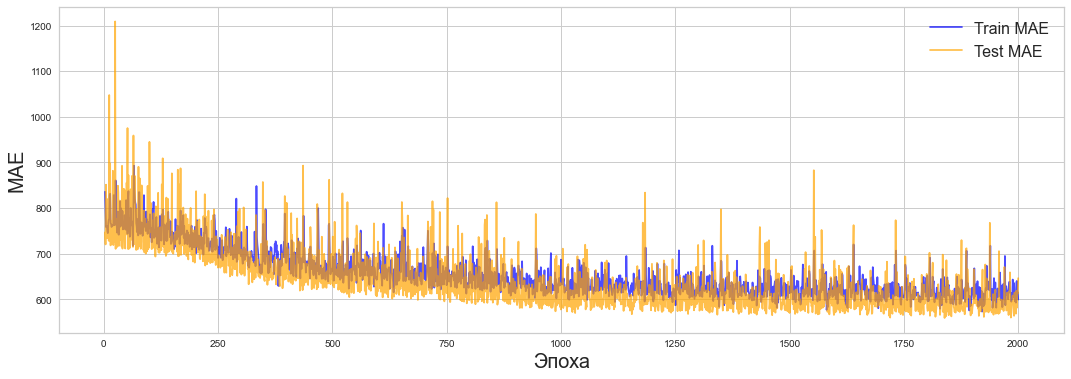

In [58]:
plt.figure(figsize=(18,6))

x = np.arange(2000) + 1
plt.plot(x[2:], history.history['mae'][2:], color='blue', alpha=0.7, label='Train MAE')
plt.plot(x[2:], history.history['val_mae'][2:], color='orange', alpha=0.7, label='Test MAE')
plt.xlabel('Эпоха', fontsize=20)
plt.ylabel('MAE', fontsize=20)
plt.legend(fontsize=16)
plt.show()

Выведем график $R^{2}$ для 800 эпох обучения начниая со 2-ой (первые 2 значения ошибки слишком большие и помешают корректному отображению данных).

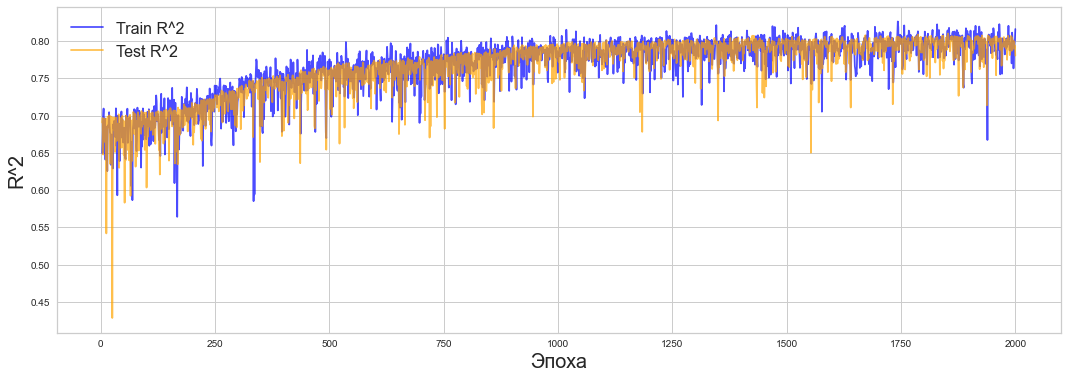

In [59]:
plt.figure(figsize=(18,6))

x = np.arange(2000) + 1
plt.plot(x[2:], history.history['R2'][2:], color='blue', alpha=0.7, label='Train R^2')
plt.plot(x[2:], history.history['val_R2'][2:], color='orange', alpha=0.7, label='Test R^2')
plt.xlabel('Эпоха', fontsize=20)
plt.ylabel('R^2', fontsize=20)
plt.legend(fontsize=16)
plt.show()

Выведем график точности предсказаний

NN test estimation:

NN MAE: 559.4323, epoch: 1838
NN R2: 0.8102, epoch: 1852

Compare NN with standart Linear model:

MAE changes: +24.9044
R2 changes: -0.0509




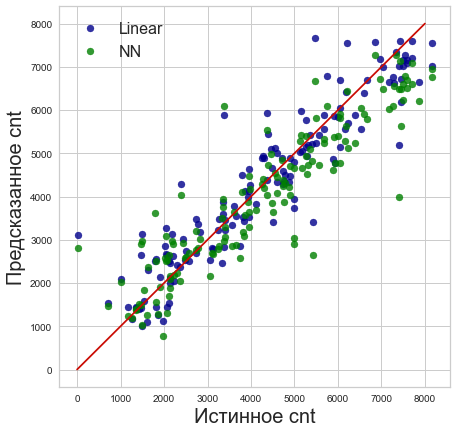

In [63]:
print('NN test estimation:\n')

NN_results = {}

NN_best_MAE_epoch = np.array(history.history['val_mae']).argmin()
NN_results['test_MAE'] = history.history['val_mae'][NN_best_MAE_epoch]
print('NN MAE: {}, epoch: {}'.format(round(NN_results['test_MAE'], 4), NN_best_MAE_epoch))

NN_best_R2_epoch = np.array(history.history['val_R2']).argmax()
NN_results['test_R2'] = history.history['val_R2'][NN_best_R2_epoch]
print('NN R2: {}, epoch: {}'.format(round(NN_results['test_R2'], 4), NN_best_R2_epoch))

print('\nCompare NN with standart Linear model:\n')
make_comparisons(NN_results, baseline_res)

plt.figure(figsize=(7, 7))
plt.scatter(y_test, baseline_clf.predict(X_test), color='darkblue', label='Linear', alpha=0.8)
plt.scatter(y_test,  NN.predict(X_test), color='green', label='NN', alpha=0.8) 
plt.plot([0, 8000], [0, 8000], color='r')
plt.xlabel('Истинное cnt', fontsize=20)
plt.ylabel('Предсказанное cnt', fontsize=20)
plt.legend(fontsize=16)
plt.show()

### 4. Доверительный интервал предсказаний полученной модели

Выполним оценку доверительных интервалов для предсказаний модели


95% доверительный интервал для модели Best model регрессии

Нижняя граница для 95% довериельного интервала предсказаний модели: -1314.969986744194
Верхняя граница для 95% довериельного интервала предсказаний модели: 1138.064385326744

Cтандартное отклонение для ошибки 590.4541164110699 на тестовом наборе данных Best model

95% доверительный интервал для модели Base model регрессии

Нижняя граница для 95% довериельного интервала предсказаний модели: -1733.8068352617431
Верхняя граница для 95% довериельного интервала предсказаний модели: 1227.6699632586754

Cтандартное отклонение для ошибки 745.6473897178125 на тестовом наборе данных Base model


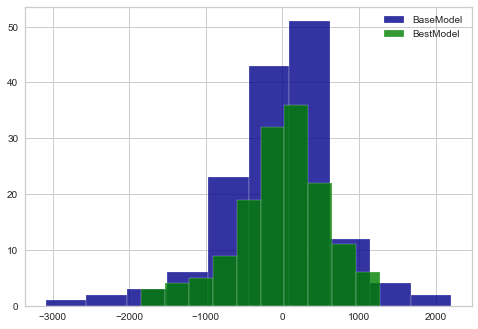

In [61]:
best_model = poly_clf
diff_best_model = y_test - best_model.fit(X_train, y_train).predict(X_test)

p1_95, p2_95 = np.percentile(diff_best_model, 2.5), np.percentile(diff_best_model, 97.5)
print('\n95% доверительный интервал для модели {} регрессии\n'.format('Best model'))
print('Нижняя граница для 95% довериельного интервала предсказаний модели: {}'.format(p1_95))
print('Верхняя граница для 95% довериельного интервала предсказаний модели: {}'.format(p2_95))

print("\nCтандартное отклонение для ошибки {} на тестовом наборе данных {}".format(np.var(diff_best_model) ** 0.5, 'Best model'))

p1_95, p2_95 = np.percentile(diff_base_model, 2.5), np.percentile(diff_base_model, 97.5)
print('\n95% доверительный интервал для модели {} регрессии\n'.format('Base model'))
print('Нижняя граница для 95% довериельного интервала предсказаний модели: {}'.format(p1_95))
print('Верхняя граница для 95% довериельного интервала предсказаний модели: {}'.format(p2_95))

print("\nCтандартное отклонение для ошибки {} на тестовом наборе данных {}".format(np.var(diff_base_model) ** 0.5, 'Base model'))

diff_base_model.hist(color = 'darkblue', alpha=0.8, label = 'BaseModel')
diff_best_model.hist(color = 'green', alpha=0.8, label = 'BestModel')
plt.legend()
plt.show()